### Reading Data

### Statistics - Visualizations

### Data Augmentations

### Training - Evaluation

### Grad-CAM

# Reading images from dataset, displaying  statistics

In [1]:
import numpy as np                      ### ARRAY MANIPULATION
import pandas as pd                     ### PROVIDES STATISTICS FROM DATAFRAMES
import cv2                              ### IMAGE MANIPULATION
import os                               ### FILE MANIPULATION
import torch                            ### DEEP LEARNING FRAMEWORK
from tqdm import tqdm                   ### MEASURES TIME IN A BAR
from matplotlib import pyplot as plt    ### PLOTS, SUBPLOTS 
import random                           ### SET FOR REPRODUCIBILITY
import time                             ### MEASURES TIME 


In [69]:
### CONTAINS INFORMATION ABOUT THE CURRENT RUN: WHICH IMAGES ARE BEING USED, WHICH DATASET AUGMENTATIONS, IF RESAMPLING IS USED, 
filename_dataset = 'OPTICAL'                  ### AVAILABLE PARAMS: FUSION, OPTICAL, IR

filename_resample = 'NO_RESAMPLE'            ### AVAILABLE PARAMS: NO_RESAMPLE, MILD_RESAMPLE, HEAVY_RESAMPLE

filename_augmentation = "NO_AUG"             ### AVAILABLE PARAMS: NO_AUG, SIMPLE_AUG, HEAVY_AUG

filename_params = filename_dataset + "_" + filename_resample + "_" + filename_augmentation

print(filename_params)

hyper_learning_rate = 0.00003


OPTICAL_NO_RESAMPLE_NO_AUG


In [3]:
if "FUSION" in filename_params:
    hyper_input_channels = 6
else:
    hyper_input_channels = 3 

print(hyper_input_channels)       

3


In [4]:
### RANDOM SEEDS FOR REPRODUCIBLE RESULTS
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
class_labels = ['no_runaway', 'runaway'] ### ORIGINAL LABELS FROM DATASET

### FUNCTIONS TO READ AND PREPROCESS THE IMAGES FROM THE FOLDERS

In [6]:
def bgr_to_rgb(img):
    """
    Convert BGR opencv format to RGB
    Input: image as read by opencv
    Returns: Image in RGB format
    """

    rgb_out = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return rgb_out

In [7]:
import cv2
import os
from tqdm import tqdm

def crop_image(img, x, y, width, height):
    """
    Crop the image to a specific rectangle.

    Inputs:
    - img: numpy array, the image to crop.
    - x: int, the x coordinate of the top-left corner of the crop rectangle.
    - y: int, the y coordinate of the top-left corner of the crop rectangle.
    - width: int, the width of the crop rectangle.
    - height: int, the height of the crop rectangle.

    Returns:
    - cropped_img: numpy array, the cropped image.
    """
    # Crop the image using numpy slicing
    cropped_img = img[y:y+height, x:x+width]
    return cropped_img


In [8]:
### DICTIONARY TO CONVERT FROM ORIGINAL LABELS TO CATEGORICAL
label2id = {'no_runaway' : 0,
            'runaway': 1}

print(label2id)

### REVERSE DICTIONARY FROM ABOVE
id2label = {0: "no_runaway",
           1: "runaway"}

print(id2label)

{'no_runaway': 0, 'runaway': 1}
{0: 'no_runaway', 1: 'runaway'}


In [9]:
def split_into_ir_optical(original_6_channel_image):
    """
    Take a fused 6 channel image and return the optical and infrared images

    Input: numpy array shaped (width, height, 6)

    Returns: 2 numpy arrays, each shaped (width, height, 3)
    """
    optical_out = original_6_channel_image[:, :, :3]
    ir_out = original_6_channel_image[:, :, 3:]

    return optical_out, ir_out

In [10]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

### USE THE FOLLOWING CELLS FOR FUSED IMAGES

def load_and_pair_images(optical_dir, infrared_dir, label):
    optical_images = sorted([os.path.join(optical_dir, f) for f in os.listdir(optical_dir) if f.endswith(".bmp")]) ### SORT AND LIST ALL BMP IMAGES IN THE OPTICAL DIRECTORY
    infrared_images = sorted([os.path.join(infrared_dir, f) for f in os.listdir(infrared_dir) if f.endswith(".bmp")]) ### SORT AND LIST ALL BMP IMAGES IN THE INRFARED DIRECTORY
    
    paired_images = []   ### LIST THAT STORES ALL FUSED IMAGES
    labels = []   ### LIST THAT STORES ALL CORRESPONDING LABELS
    min_len = min(len(optical_images), len(infrared_images))    ### FIND THE SMALLEST NUMBER OF IMAGES BETWEEN INFRARED AND OPTICAL FOR THE SAME SUBDIR

    ### PRINT A MESSAGE IF THERE IS A MISMATCH
    if len(optical_images) != len(infrared_images):
        print(optical_dir, "   ", infrared_dir)
        print(len(optical_images), len(infrared_images))

    for i in range(min_len):
        img_optical = cv2.imread(optical_images[i], cv2.IMREAD_COLOR)  ### LOADS THE I-TH OPTICAL IMAGE
        img_infrared = cv2.imread(infrared_images[i], cv2.IMREAD_COLOR)  ### LOADS THE I-TH IR IMAGE
        
        if img_optical is not None and img_infrared is not None:
            img_optical = cv2.resize(img_optical, (224, 224))  ### RESIZE TO STANDARD SIZE 224, 224
            img_infrared = crop_image(img_infrared, 29, 73, 657-29, 544-73)  ### CROP INFRARED IMAGE TO EXCLUDE TITLE, TEMPERATURE SCALE ETC
            img_infrared = cv2.resize(img_infrared, (224, 224)) ### RESIZE THE INFRARED AFTER CROPPING
            
            ### CONCATENATE OPTICAL AND INFRARED IMAGES ALONG THE CHANNEL AXES
            fused_image = np.concatenate((img_optical, img_infrared), axis=2)
            paired_images.append(fused_image)  ### APPEND THE LIST OF FUSED IMAGES WITH THE CURRENT ONE
            labels.append(label)  ### ADD THE CORRESPONDING LABEL TO THE LABEL LIST
    return paired_images, labels

def process_subdirectories(main_folder, label):
    optical_folder = os.path.join(main_folder, "optical") ### DEFINE THE PATHS TO THE OPTICAL AND INFRARED SUBDIRECTORIES
    infrared_folder = os.path.join(main_folder, "ir")
    
    optical_subdirs = [os.path.join(optical_folder, d) for d in sorted(os.listdir(optical_folder)) if os.path.isdir(os.path.join(optical_folder, d))] ### LIST SUBDIRECTORIES WITHIN THE OPTICAL AND INFRARED FOLDERS
    infrared_subdirs = [os.path.join(infrared_folder, d) for d in sorted(os.listdir(infrared_folder)) if os.path.isdir(os.path.join(infrared_folder, d))]
    
    assert len(optical_subdirs) == len(infrared_subdirs), "Optical and Infrared folders mismatch!" ### ASSERT THAT THE NUMBER OF SUBDIRECTORIES IN OPTICAL AND INFRARED ARE EQUAL, SO THE FUSION WORKS
    
    subdirs_pairs = list(zip(optical_subdirs, infrared_subdirs)) ### PAIR THE SUBDIRECTORIES: CG1 GOES TO IR1, ETC
    train_pairs, test_pairs = train_test_split(subdirs_pairs, train_size=0.85, test_size=0.15, random_state=42) ### SPLIT THE SUBDIRECTORY PAIRS INTO TRAIN, VAL, AND TEST
    train_pairs, val_pairs = train_test_split(train_pairs, train_size=0.7 / 0.85, test_size=0.15 / 0.85, random_state=42) 
    
    return train_pairs, val_pairs, test_pairs

def load_data_for_set(subdir_pairs, label):
    images = []  ### LIST THAT STORES ALL IMAGES
    labels = []  ### LIST THAT STORES ALL LABELS
    
    for optical_subdir, infrared_subdir in subdir_pairs:  ### LOOP EACH PAIR OF SUBDIRECTORIES
        
        imgs, lbls = load_and_pair_images(optical_subdir, infrared_subdir, label) ### LOAD AND PAIR IMAGES FROM THE CURRENT PAIR
        images.extend(imgs)  ### ADD LOADED IMAGES TO THE LIST
        labels.extend(lbls)  ### ADD CORESSPONDING LABELS TO THE LIST
    return images, labels

In [11]:
# ### FUNCTIONS TO LOAD NON-FUSED IMAGES

# import os
# import cv2
# import numpy as np

# def load_images_from_folder(folder, label):

#     """
#     Load every bmp from every subdirectory 

#     Input: Folder that holds the images, and its respective label

#     Returns: 2 lists, 1 with the images and 1 with the labels
#     """
#     images = []
#     labels = []
#     ### MAIN SUBDIRECTORY
#     for subdir in tqdm(os.listdir(folder)):
#         path = os.path.join(folder, subdir)
#         ### CHECK IF IT IS A SUBDIRECTORY
#         if os.path.isdir(path):
#             ### GO THROUGH THE SUBDIRECTORIES
#             for filename in os.listdir(path):
#                 img_path = os.path.join(path, filename)
#                 ### CHECK IF THE IMAGE IS NOT CORRUPTED
#                 if img_path.endswith(".bmp"):
#                     img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#                     if "IR" in filename_params:
#                         img = crop_image(img, 29, 73, 657-29, 544-73) ################################### ONLY DO THIS IN IR IMAGES
#                     img = cv2.resize(img,(224,224))
#                     if img is not None:
#                         images.append(img)
#                         labels.append(label)
#     return images, labels


# def load_single_image_from_folder(folder, label):
#     """
#     Load only 1 bmp from every subdirectory 

#     Input: Folder that holds the images, and its respective label

#     Returns: 2 lists, 1 with the images and 1 with the labels
#     """

#     images = []  # LIST TO STORE IMAGES.
#     labels = []  # LIST TO STORE LABELS CORRESPONDING TO EACH IMAGE.

#     # TRAVERSE THE MAIN DIRECTORY
#     for subdir in tqdm(os.listdir(folder)):  # TQDM SHOWS A PROGRESS BAR FOR THE LOOP OVER SUBDIRECTORIES.
#         path = os.path.join(folder, subdir)  # JOIN THE FOLDER PATH AND SUBDIRECTORY NAME.

#         # CHECK IF IT'S A DIRECTORY
#         if os.path.isdir(path):  # ONLY PROCESS IF IT IS A DIRECTORY.
#             # TRAVERSE EACH SUBDIRECTORY WITHIN THE MAIN DIRECTORY
#             for filename in os.listdir(path):  # LIST EACH FILE IN THE SUBDIRECTORY.
#                 img_path = os.path.join(path, filename)  # CREATE THE FULL IMAGE PATH.

#                 # CHECK IF THE FILE IS AN IMAGE
#                 if img_path.endswith(".bmp"):  # PROCESS ONLY BMP FILES.
#                     img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # READ THE IMAGE IN COLOR.
#                     if "IR" in filename_params:
#                         img = crop_image(img, 29, 73, 657-29, 544-73)  # CROP THE IMAGE.
#                     img = cv2.resize(img, (224, 224))  # RESIZE THE IMAGE TO 224X224 PIXELS.

#                     if img is not None:  # CHECK IF THE IMAGE WAS LOADED (NOT CORRUPTED).
#                         images.append(img)  # ADD THE IMAGE TO THE LIST OF IMAGES.
#                         labels.append(label)  # ADD THE CORRESPONDING LABEL TO THE LIST OF LABELS.
#                         break  # BREAK THE INNER LOOP AFTER PROCESSING THE FIRST IMAGE.

#     return images, labels  # RETURN THE LISTS OF IMAGES AND LABELS.



In [12]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_images(dirs, label):
    images = []
    labels = []
    for subdir in tqdm(dirs):
        for filename in os.listdir(subdir):
            img_path = os.path.join(subdir, filename)
            if img_path.endswith(".bmp"):
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if "IR" in filename_params:
                    img = crop_image(img, 29, 73, 657-29, 544-73)
                img = cv2.resize(img, (224, 224))
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

def load_images_from_subdirs(folder, label, train_size=0.7, val_size=0.15, test_size=0.15):
    
    subdirs = [os.path.join(folder, d) for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    train_dirs, test_dirs = train_test_split(subdirs, train_size=train_size + val_size, test_size=test_size, random_state=42)
    train_dirs, val_dirs = train_test_split(train_dirs, train_size=train_size / (train_size + val_size), test_size=val_size / (train_size + val_size), random_state=42)

    train_images, train_labels = load_images(train_dirs, label)
    val_images, val_labels = load_images(val_dirs, label)
    test_images, test_labels = load_images(test_dirs, label)

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [13]:
if "FUSION" in filename_params: ### IF WE ARE WORKING WITH THE FUSED IMAGES
    print("WORKING WITH FUSED IMAGES (6 CHANNELS)")
    class0_folder = 'C:/Users/N/Desktop/Data_VDL_Final/No-Runaway/'
    class1_folder = 'C:/Users/N/Desktop/Data_VDL_Final/Runaway'
    label0 = 0  ### LABEL FOR NO RUNAWAY
    label1 = 1  ### LABEL FOR RUNAWAY

    start = time.time()
    ### CLASS 0
    train_pairs0, val_pairs0, test_pairs0 = process_subdirectories(class0_folder, label0)
    train_images0, train_labels0 = load_data_for_set(train_pairs0, label0)
    val_images0, val_labels0 = load_data_for_set(val_pairs0, label0)
    test_images0, test_labels0 = load_data_for_set(test_pairs0, label0)

    ### CLASS 1
    train_pairs1, val_pairs1, test_pairs1 = process_subdirectories(class1_folder, label1)
    train_images1, train_labels1 = load_data_for_set(train_pairs1, label1)
    val_images1, val_labels1 = load_data_for_set(val_pairs1, label1)
    test_images1, test_labels1 = load_data_for_set(test_pairs1, label1)
    train_images = train_images0 + train_images1
    train_labels = train_labels0 + train_labels1

    val_images = val_images0 + val_images1
    val_labels = val_labels0 + val_labels1

    test_images = test_images0 + test_images1
    test_labels = test_labels0 + test_labels1

    print(len(train_images), len(train_labels))
    print(len(val_images), len(val_labels))
    print(len(test_images), len(test_labels))

else:
    if "OPTICAL" in filename_params:
        print("WORKING WITH OPTICAL IMAGES")

        folder_path_negative = 'C:/Users/N/Desktop/Data_VDL_Final/No-Runaway/optical'
        label_negative = 0
        (train_negative_images, train_negative_labels), (val_negative_images, val_negative_labels), (test_negative_images, test_negative_labels) = load_images_from_subdirs(folder_path_negative, label_negative)

        folder_path_positive = 'C:/Users/N/Desktop/Data_VDL_Final/Runaway/optical'
        label_positive = 1
        (train_positive_images, train_positive_labels), (val_positive_images, val_positive_labels), (test_positive_images, test_positive_labels) = load_images_from_subdirs(folder_path_positive, label_positive)
    elif "IR" in filename_params:
        print('WORKING WITH INFRARED IMAGES')
        folder_path_negative = 'C:/Users/N/Desktop/Data_VDL_Final/No-Runaway/ir'
        label_negative = 0
        (train_negative_images, train_negative_labels), (val_negative_images, val_negative_labels), (test_negative_images, test_negative_labels) = load_images_from_subdirs(folder_path_negative, label_negative)

        folder_path_positive = 'C:/Users/N/Desktop/Data_VDL_Final/Runaway/ir'
        label_positive = 1
        (train_positive_images, train_positive_labels), (val_positive_images, val_positive_labels), (test_positive_images, test_positive_labels) = load_images_from_subdirs(folder_path_positive, label_positive)
    else:
        print('ERROR! CHECK PARAMS AGAIN', "="*100)        

    print(len(train_negative_images), len(train_negative_labels))
    print(len(val_negative_images), len(val_negative_labels))
    print(len(test_negative_images), len(test_negative_labels))
    print('')
    print(len(train_positive_images), len(train_positive_labels))
    print(len(val_positive_images), len(val_positive_labels))
    print(len(test_positive_images), len(test_positive_labels))
    print('-'*50)
    train_images = train_negative_images + train_positive_images
    train_labels = train_negative_labels + train_positive_labels

    val_images = val_negative_images + val_positive_images
    val_labels = val_negative_labels + val_positive_labels

    test_images = test_negative_images + test_positive_images
    test_labels = test_negative_labels + test_positive_labels

    print(len(train_images), len(train_labels))
    print(len(val_images), len(val_labels))
    print(len(test_images), len(test_labels))
    print('')
    print(train_images[0].shape)
    print(val_images[0].shape)
    print(test_images[0].shape)

WORKING WITH OPTICAL IMAGES


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]

282 282
60 60
73 73

280 280
60 60
80 80
--------------------------------------------------
562 562
120 120
153 153

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


### Displaying images for each category

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import random


def plot_label_examples_fused(images, labels, figure_title="Image Samples"):
    """
    Displays 4 random example pairs of images (each split into two 3-channel images) for each label in a subplot,
    with the examples for each label arranged vertically. Each row now contains two images side by side for the same datapoint.
    Allows for setting a random seed for reproducibility.
    
    Parameters:
    - images: A list of images (each one as a numpy array with 6 channels).
    - labels: A list of labels corresponding to each image.
    - random_seed: An optional integer to control randomness for reproducibility.
    """

    unique_labels = sorted(set(labels))  # Finds unique labels from the dataset
    
    # Create a subplot with 4 rows and 2 * number of unique labels columns
    fig, axs = plt.subplots(4, 2 * len(unique_labels), figsize=(10 * len(unique_labels), 20))
    
    if len(unique_labels) == 1:
        axs = axs.reshape(4, 2)  # Ensure the axs is properly shaped when there is only one label

    for col, label in enumerate(unique_labels):
        label_indices = [idx for idx, current_label in enumerate(labels) if current_label == label]
        random.shuffle(label_indices)  # Randomly shuffle the indices of the images
        
        selected_indices = label_indices[:4]
        for row, img_idx in enumerate(selected_indices):
            img = images[img_idx]
            if img.shape[0] == 6:
                img = img.transpose(1,2,0)

            optical_img, ir_img = split_into_ir_optical(img)  # Split the 6-channel image into two 3-channel images
            
            # IR image on the left
            ax_left = axs[row, 2 * col]
            ax_left.imshow(optical_img)
            ax_left.axis('off')
            
            # Optical image on the right
            ax_right = axs[row, 2 * col + 1]
            ax_right.imshow(bgr_to_rgb(ir_img))
            ax_right.axis('off')
            
            if row == 0:
                ax_right.set_title(f'Respective {id2label[label]} IR', fontsize=18)  # Title for IR
                ax_left.set_title(f'{id2label[label]} Optical', fontsize=18)  # Title for Optical

    fig.suptitle(figure_title, fontsize=24, verticalalignment='top')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    filename_second = figure_title.replace(" ", "_")
    filename = f"Images/{filename_second}.png"
    if not os.path.exists(filename):
        plt.savefig(filename, bbox_inches='tight')
        print(f"Image Successfully Saved at {filename}")
    else:
        print(f"File {filename} already exists, skipping save.")
    plt.show()


#plot_label_examples_fused(train_images, train_labels, random_seed=12, figure_title = "TRAIN IMAGE EXAMPLES")
#plot_label_examples_fused(val_images, val_labels, random_seed=42, figure_title = "VALIDATION IMAGE EXAMPLES")
#plot_label_examples_fused(test_images, test_labels, random_seed=42, figure_title = "TEST IMAGE EXAMPLES")

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_label_examples(images, labels, figure_title = "Example Images"):
    """
    Displays 4 random example images for each label in a subplot, with the examples
    for each label arranged vertically. Allows for setting a random seed for reproducibility.
    
    Parameters:
    - images: A list of images (each one as a numpy array).
    - labels: A list of labels corresponding to each image.
    - random_seed: An optional integer to control randomness for reproducibility.
    """
        
    unique_labels = sorted(set(labels)) ### FINDS UNIQUE LABELS FROM DATASET
    
    fig, axs = plt.subplots(4, len(unique_labels), figsize=(5 * len(unique_labels), 20))
    
    
    if len(unique_labels) == 1:
        axs = np.array([[ax] for ax in axs])

    
    for col, label in enumerate(unique_labels): ### REPEAT FOR EVERY LABEL
        
        label_indices = [idx for idx, current_label in enumerate(labels) if current_label == label] ### FIND INDICES OF LABELS
        
        
        random.shuffle(label_indices) ### RANDOMLY SHUFFLE IMAGES
        
        
        selected_indices = label_indices[:4]
        for row, img_idx in enumerate(selected_indices):
            img = images[img_idx]
            if img.shape[0] == 3:
                img = img.transpose(1,2,0)
            ax = axs[row, col]
            ax.imshow(bgr_to_rgb(img), cmap='gray', vmin=0, vmax=255)  ### PRINT IMAGES AS GRAYSCALE, EVEN WHEN THEY ARE RGB-LIKE
            ax.axis('off')
            if row == 0:
                ax.set_title(f'{id2label[label]}', fontsize=36)  ### INCREASE FONT SIZE FOR EASIER READABILITY

    
    fig.suptitle(figure_title, fontsize=24, verticalalignment='top')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


#plot_label_examples(train_images, train_labels, random_seed=42, figure_title = "TRAIN IMAGE EXAMPLES")
#plot_label_examples(val_images, val_labels, random_seed=42, figure_title = "VAL IMAGE EXAMPLES")
#plot_label_examples(test_images, test_labels, random_seed=42, figure_title = "TEST IMAGE EXAMPLES")



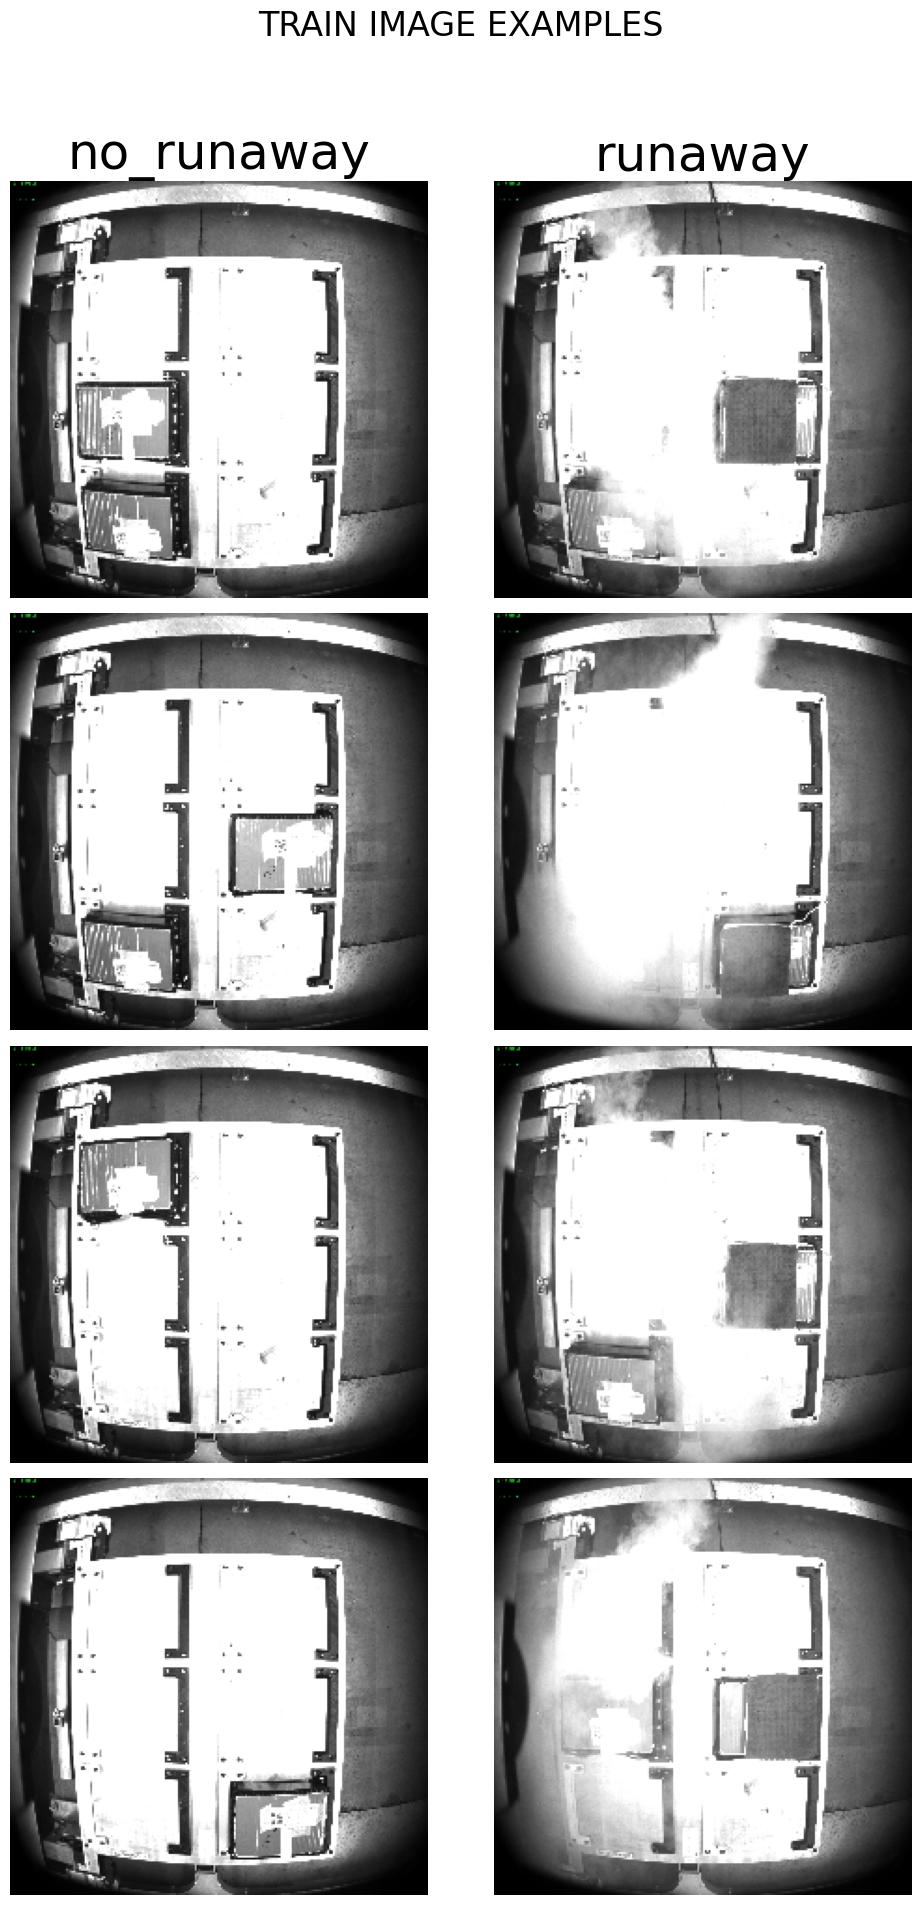

In [16]:
if hyper_input_channels == 6:
    plot_label_examples_fused(train_images, train_labels, figure_title = "TRAIN IMAGE EXAMPLES")
else:
    plot_label_examples(train_images, train_labels, figure_title = "TRAIN IMAGE EXAMPLES")


In [17]:
### MAKE SURE THAT THE UNIQUE LABELS ARE STILL THE SAME
np.unique(train_labels)

array([0, 1])

File Images/Initial_Label_Split.png already exists, skipping save.


C:\Users\N\AppData\Local\Temp\ipykernel_19444\896891100.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(["No Runaway","Runaway"])


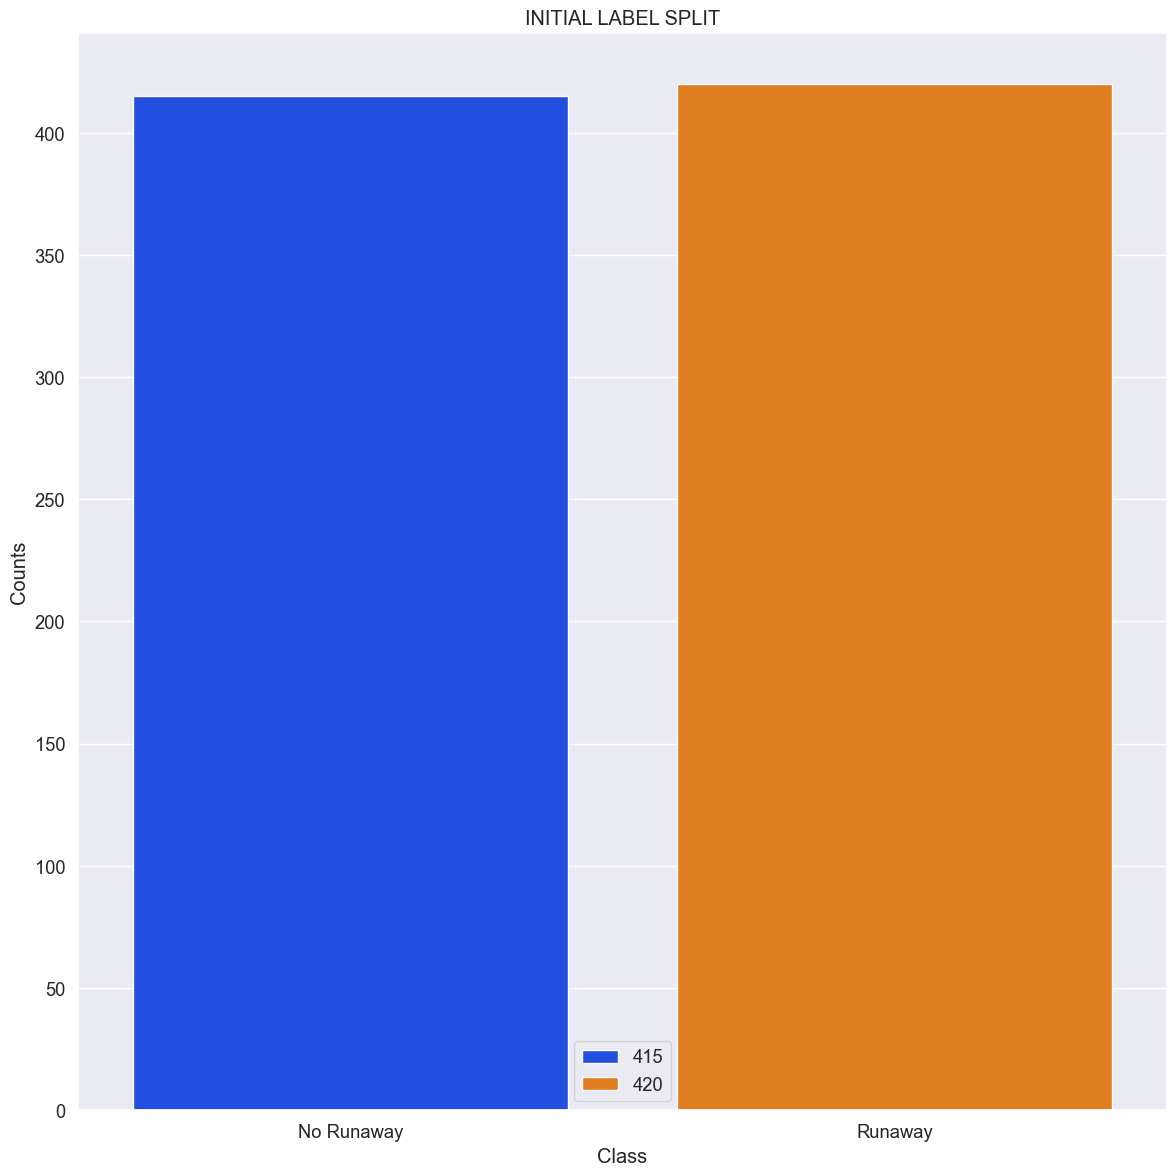

In [18]:
### VISUALIZE LABEL SPLITS IN INITIAL DATASET
import seaborn as sns
sns.set(font_scale = 1.2)

fig, axs = plt.subplots(1, 1, figsize=(12, 12))

values, counts = np.unique(train_labels+val_labels+test_labels, return_counts=True)

counts_perc = counts / counts.sum()
sns.barplot(x=values, y=counts, palette='bright', hue=counts, ax=axs)
# for bars in ax.containers:
#         ax.bar_label(bars, fmt='%.0f')
#ax.bar_label(ax.containers[0])
plt.title('INITIAL LABEL SPLIT')
axs.set(xlabel='Class', ylabel='Counts')
axs.set_xticklabels(["No Runaway","Runaway"])
plt.tight_layout()

filename = "Images/Initial_Label_Split.png"
if not os.path.exists(filename):
    plt.savefig(filename, bbox_inches='tight')
    print("Image Sucessfully Saved!")
else:
    print(f"File {filename} already exists, skipping save.")

plt.show()

In [19]:
from sklearn.utils import shuffle

### MAKING THE LISTS INTO NUMPY ARRAYS

print(type(train_images))
print(type(train_labels))
train_images = np.array(train_images)
train_labels = np.array(train_labels)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)


print(type(train_images))
print(type(train_labels))

print(train_images.shape)
print(train_labels.shape)

# X_shuffled_rgb, y_shuffled_rgb = shuffle(train_images, train_labels, random_state=42) ### SHUFFLING TO RE-ORDER DATA 

# print(X_shuffled_rgb.shape)
# print(y_shuffled_rgb.shape)

<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(562, 224, 224, 3)
(562,)


# Augmentations, Resampling

In [20]:
from torchvision import transforms
from PIL import Image


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class SaltAndPepperNoise(object):
    """
    Apply salt and pepper noise to an image.
    """
    def __init__(self, amount=0.005, salt_vs_pepper=0.5):
        self.amount = amount
        self.salt_vs_pepper = salt_vs_pepper

    def __call__(self, img):
        ### CONVERT TO NUMPY ARRAY FOR EASIER MANIPULATION
        img = np.array(img)
        ### CALCULATE THE AMOUNT OF PIXELS TO MODIFY
        num_salt = np.ceil(self.amount * img.size * self.salt_vs_pepper)
        num_pepper = np.ceil(self.amount * img.size * (1.0 - self.salt_vs_pepper))

        ### APPLY SALT
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
        img[tuple(coords)] = 255

        ### APPLY PEPPER 
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
        img[tuple(coords)] = 0

        return img


if filename_augmentation == "NO_AUG":
    augmentations_train = transforms.Compose([
    transforms.ToTensor()
                                            ])

    augmentations_val = transforms.Compose([
    transforms.ToTensor()
                                            ])   
elif filename_augmentation == "SIMPLE_AUG" :

    ### AUGMENTATIONS FOR THE TRAIN DATASET
    augmentations_train = transforms.Compose([
        transforms.ToTensor(),                                                                                               
        transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.5),                                               
        transforms.RandomApply([transforms.RandomRotation(40)], p=0.5),                                                 
        transforms.RandomApply([transforms.RandomAffine(degrees=25, translate=(0.1, 0.1), scale=(0.85, 1.15))], p=1.), 
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=1.0),                                        
        transforms.RandomApply([SaltAndPepperNoise(amount=0.05, salt_vs_pepper=0.5)], p=0.5)
        
                                            ])

    ### AUGMENTATIONS FOR THE VALIDATION AND TEST DATASETS
    augmentations_val = transforms.Compose([
        transforms.ToTensor()
                                            ])
elif filename_augmentation == "HEAVY_AUG":

    ### AUGMENTATIONS FOR THE TRAIN DATASET
    augmentations_train = transforms.Compose([
        transforms.ToTensor(),                                                                                               
        transforms.RandomApply([transforms.RandomHorizontalFlip()], p=1.),                                               
        transforms.RandomApply([transforms.RandomRotation(50)], p=1.),                                                 
        transforms.RandomApply([transforms.RandomAffine(degrees=25, translate=(0.1, 0.1), scale=(0.85, 1.15))], p=1.), 
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=1.0),                                        
        transforms.RandomApply([SaltAndPepperNoise(amount=0.1, salt_vs_pepper=0.5)], p=1.)
        
                                            ])

    ### AUGMENTATIONS FOR THE VALIDATION AND TEST DATASETS
    augmentations_val = transforms.Compose([
        transforms.ToTensor()
                                           ])
else:
    print("ERROR IN FILENAME PARAMS, CHECK AUGMENTATIONS AGAIN")    



def generate_augmented_images(data, labs, target_count, augmentations_in):
    """
    Function to generate augmented images which are more in number from the initial ones
    Picks an image at random from the initial data, augments it, and adds it to the generated augmented images

    Inputs: the images (data), the respective labels, the desired target datapoint count, and the augmentation class

    Returns: the augmented images and the respective labels as 2 numpy arrays
    """
    augmented_images = []
    augmented_labs = []

    num_images = data.shape[0]

    for _ in tqdm(range(target_count)):
        idx = np.random.randint(0, num_images)
        image_np = data[idx]
        lab = labs[idx]
        image_pil = image_np
        transformed_image_pil = augmentations_in(image_pil)
        transformed_image_np = np.array(transformed_image_pil)
        augmented_images.append(transformed_image_np)
        augmented_labs.append(lab)

    return np.array(augmented_images), np.array(augmented_labs)


def augment_images(data, labs, augmentations_in):
    """
    Function that just augments the existing images, without resampling them

    Inputs: the original images and labels, and the augmentation class

    Returns: the augmented images and the respective labels as 2 numpy arrays
    """
    augmented_images = []
    augmented_labs = []
    for idx in tqdm(range(data.shape[0])): 
        image_np = data[idx]
        lab = labs[idx]
        image_pil = image_np
        transformed_image_pil = augmentations_in(image_pil)
        transformed_image_np = np.array(transformed_image_pil)
        augmented_images.append(transformed_image_np)
        augmented_labs.append(lab)

    return np.array(augmented_images), np.array(augmented_labs)

In [21]:
train_images[0].shape

(224, 224, 3)

In [22]:
### GENERATE THE AUGMENTED IMAGES

if filename_resample == "NO_RESAMPLE":

    augmented_train_images, augmented_train_labels = augment_images(train_images, train_labels, augmentations_in=augmentations_train)
    augmented_val_images, augmented_val_labels = augment_images(val_images, val_labels, augmentations_in=augmentations_val)
    augmented_test_images, augmented_test_labels = augment_images(test_images, test_labels, augmentations_in=augmentations_val)

elif filename_resample == "MILD_RESAMPLE":
    augmented_train_images, augmented_train_labels = generate_augmented_images(train_images, train_labels, target_count=2000, augmentations_in=augmentations_train)
    augmented_val_images, augmented_val_labels = augment_images(val_images, val_labels, augmentations_in=augmentations_val)
    augmented_test_images, augmented_test_labels = augment_images(test_images, test_labels, augmentations_in=augmentations_val)

elif filename_resample == "HEAVY_RESAMPLE":
    augmented_train_images, augmented_train_labels = generate_augmented_images(train_images, train_labels, target_count=4000, augmentations_in=augmentations_train)
    augmented_val_images, augmented_val_labels = augment_images(val_images, val_labels, augmentations_in=augmentations_val)
    augmented_test_images, augmented_test_labels = augment_images(test_images, test_labels, augmentations_in=augmentations_val)    
    


100%|██████████| 153/153 [00:00<00:00, 2858.94it/s]


In [23]:
print(augmented_train_images.shape, augmented_train_labels.shape)
print('')
print(augmented_val_images.shape, augmented_val_labels.shape)
print('')
print(augmented_test_images.shape, augmented_test_labels.shape)

(562, 3, 224, 224) (562,)

(120, 3, 224, 224) (120,)

(153, 3, 224, 224) (153,)


In [24]:
type(augmented_test_images[0])

numpy.ndarray

C:\Users\N\AppData\Local\Temp\ipykernel_19444\1404758257.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=counts, palette='bright', ax=axs)
C:\Users\N\AppData\Local\Temp\ipykernel_19444\1404758257.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(["No Runaway","Runaway"])


File Images/Augmented_Train_Set_Label_Split.png already exists, skipping save.


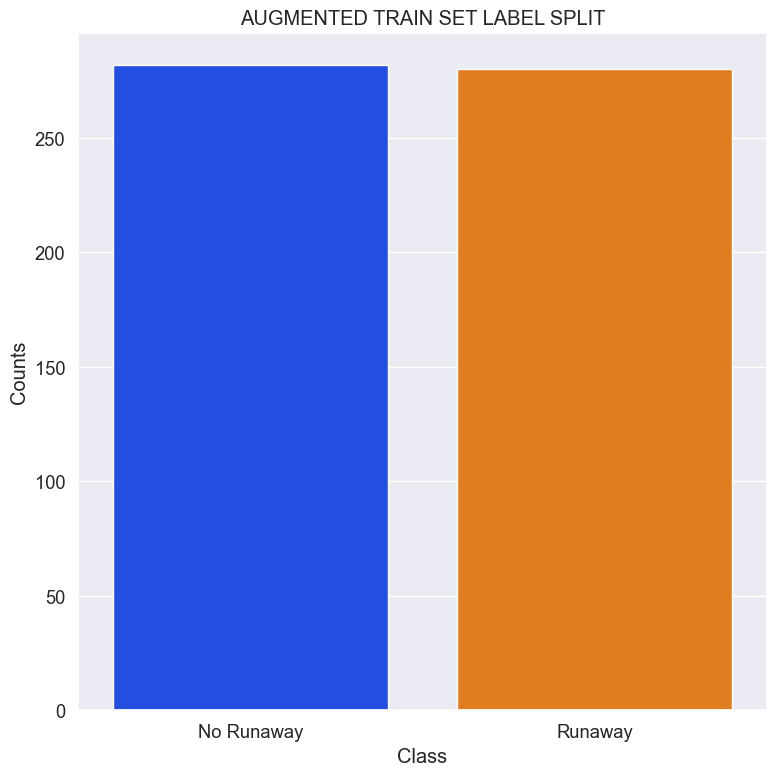

In [25]:
### VISUALIZE LABEL SPLITS IN AUGMENTED TRAIN SET
import seaborn as sns

sns.set(font_scale = 1.2)

fig, axs = plt.subplots(1, 1, figsize=(8, 8))

values, counts = np.unique(augmented_train_labels, return_counts=True)

counts_perc = counts / counts.sum()
sns.barplot(x=values, y=counts, palette='bright', ax=axs)
# for bars in ax.containers:
#         ax.bar_label(bars, fmt='%.0f')
#ax.bar_label(ax.containers[0])
plt.title('AUGMENTED TRAIN SET LABEL SPLIT')
axs.set(xlabel='Class', ylabel='Counts')
axs.set_xticklabels(["No Runaway","Runaway"])
plt.tight_layout()

filename = "Images/Augmented_Train_Set_Label_Split.png"
if not os.path.exists(filename):
    plt.savefig(filename, bbox_inches='tight')
    print("Image Successfully Saved!")
else:
    print(f"File {filename} already exists, skipping save.")
plt.show()

C:\Users\N\AppData\Local\Temp\ipykernel_19444\1122561847.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=counts, palette='bright', ax=axs)
C:\Users\N\AppData\Local\Temp\ipykernel_19444\1122561847.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(["No Runaway","Runaway"])


File Images/Validation_Set_Label_Split.png already exists, skipping save.


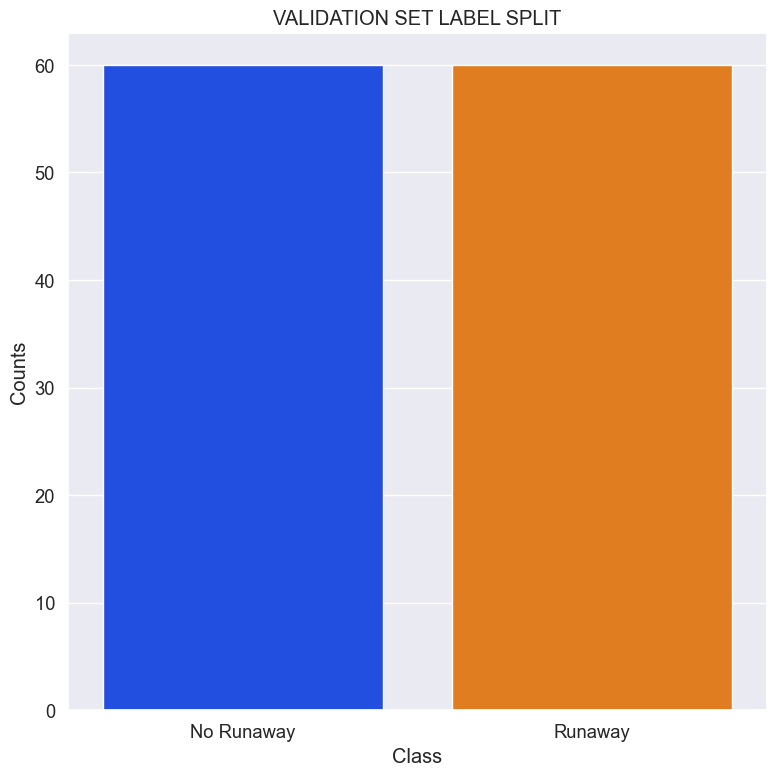

In [26]:
### VISUALIZE LABEL SPLITS IN AUGMENTED TRAIN SET
import seaborn as sns

sns.set(font_scale = 1.2)

fig, axs = plt.subplots(1, 1, figsize=(8, 8))

values, counts = np.unique(augmented_val_labels, return_counts=True)

counts_perc = counts / counts.sum()
sns.barplot(x=values, y=counts, palette='bright', ax=axs)
# for bars in ax.containers:
#         ax.bar_label(bars, fmt='%.0f')
#ax.bar_label(ax.containers[0])
plt.title('VALIDATION SET LABEL SPLIT')
axs.set(xlabel='Class', ylabel='Counts')
axs.set_xticklabels(["No Runaway","Runaway"])
plt.tight_layout()

filename = "Images/Validation_Set_Label_Split.png"
if not os.path.exists(filename):
    plt.savefig(filename, bbox_inches='tight')
    print("Image Successfully Saved!")
else:
    print(f"File {filename} already exists, skipping save.")
plt.show()

C:\Users\N\AppData\Local\Temp\ipykernel_19444\186105513.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(["No Runaway","Runaway"])


File Images/Test_Set_Label_Split.png already exists, skipping save.


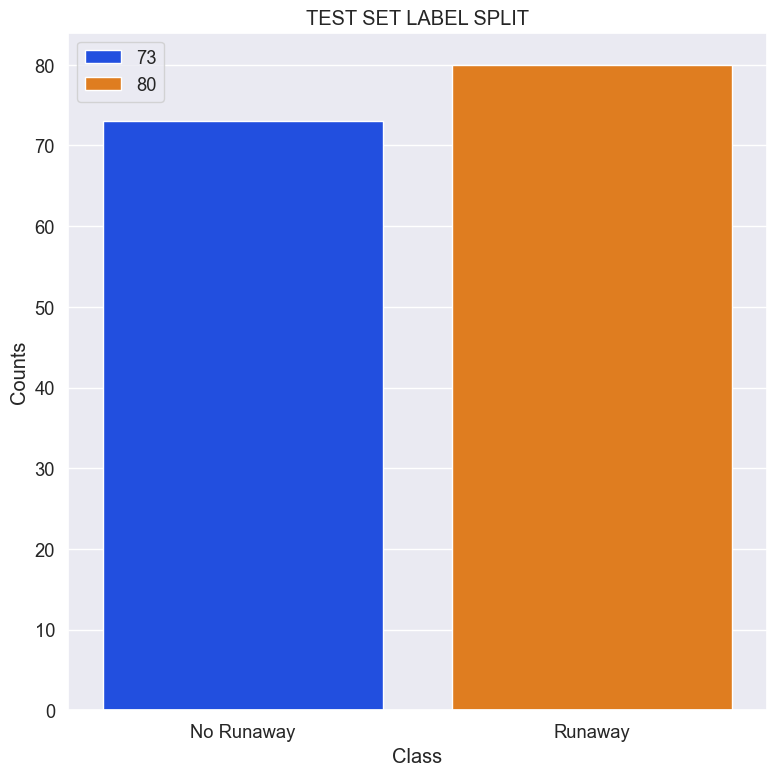

In [27]:
### VISUALIZE LABEL SPLITS IN AUGMENTED TRAIN SET
import seaborn as sns

sns.set(font_scale = 1.2)

fig, axs = plt.subplots(1, 1, figsize=(8, 8))

values, counts = np.unique(augmented_test_labels, return_counts=True)

counts_perc = counts / counts.sum()
sns.barplot(x=values, y=counts, palette='bright', hue=counts, ax=axs)
# for bars in ax.containers:
#         ax.bar_label(bars, fmt='%.0f')
#ax.bar_label(ax.containers[0])
plt.title('TEST SET LABEL SPLIT')
axs.set(xlabel='Class', ylabel='Counts')
axs.set_xticklabels(["No Runaway","Runaway"])
plt.tight_layout()

filename = "Images/Test_Set_Label_Split.png"
if not os.path.exists(filename):
    plt.savefig(filename, bbox_inches='tight')
    print("Image Successfully Saved!")
else:
    print(f"File {filename} already exists, skipping save.")

plt.show()

In [28]:
augmented_train_images[0].shape

(3, 224, 224)

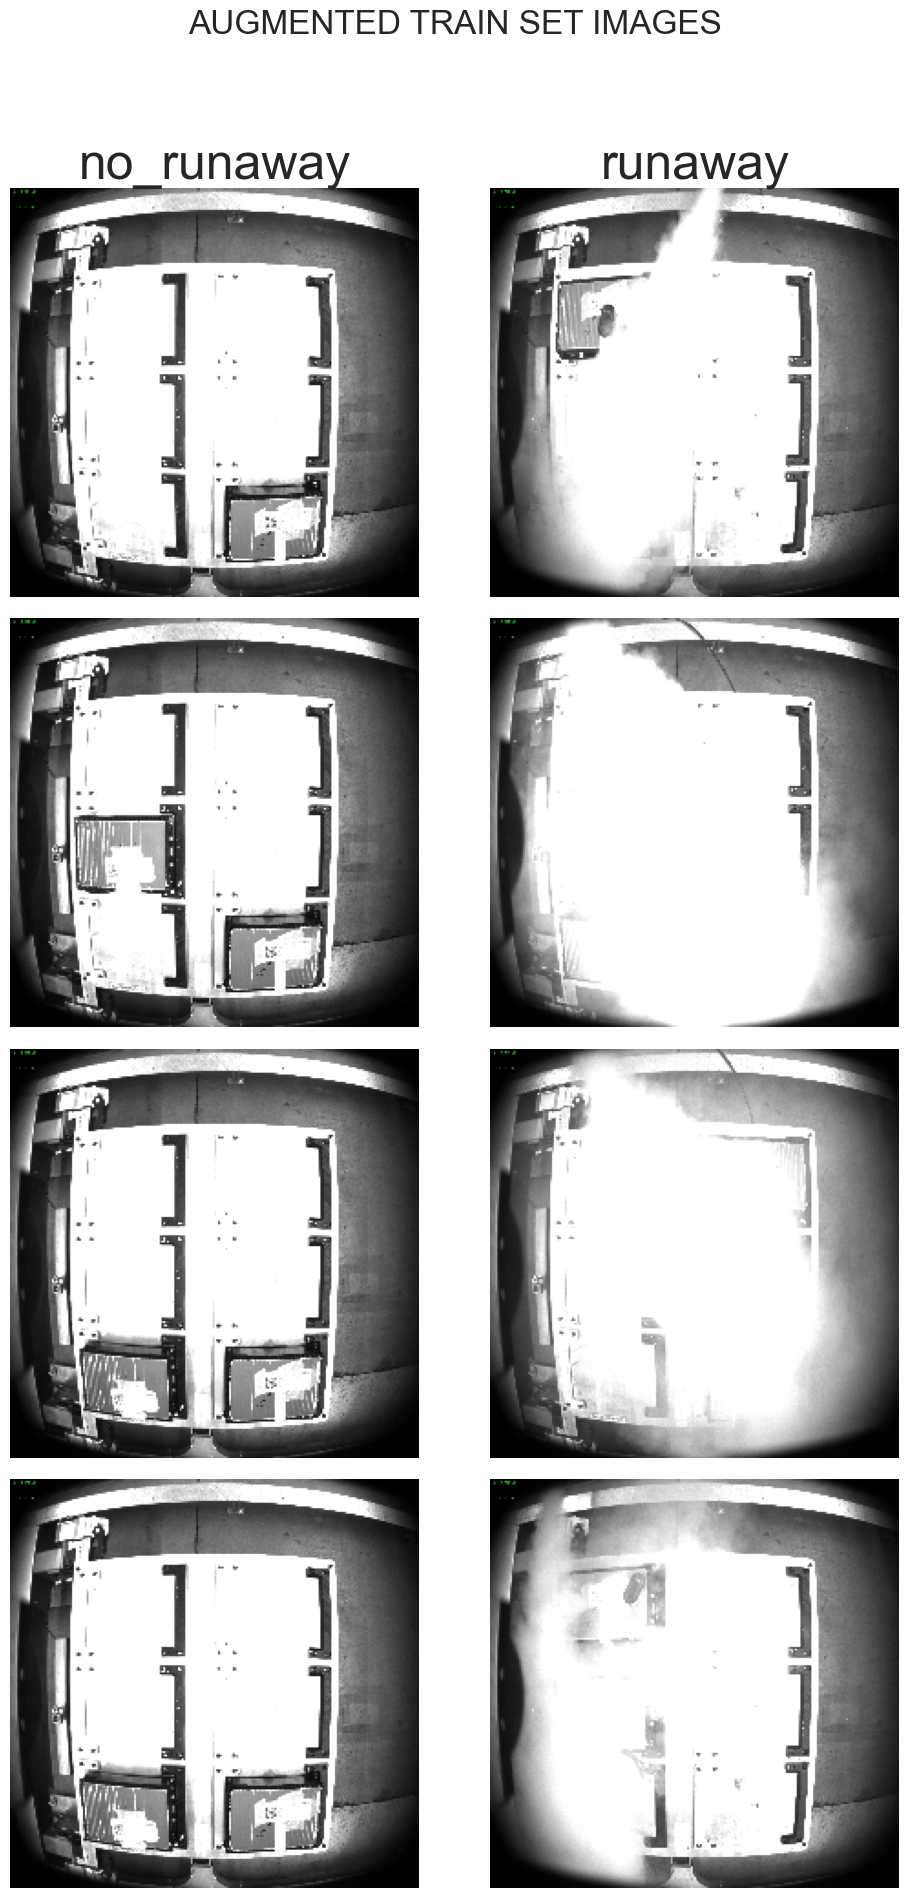

<Figure size 640x480 with 0 Axes>

In [29]:
if hyper_input_channels == 6:
    plot_label_examples_fused(augmented_train_images, augmented_train_labels, figure_title="AUGMENTED TRAIN SET IMAGES")
    plt.tight_layout()
    plt.show()
else:
    plot_label_examples(augmented_train_images, augmented_train_labels, figure_title="AUGMENTED TRAIN SET IMAGES")
    plt.tight_layout()
    plt.show()

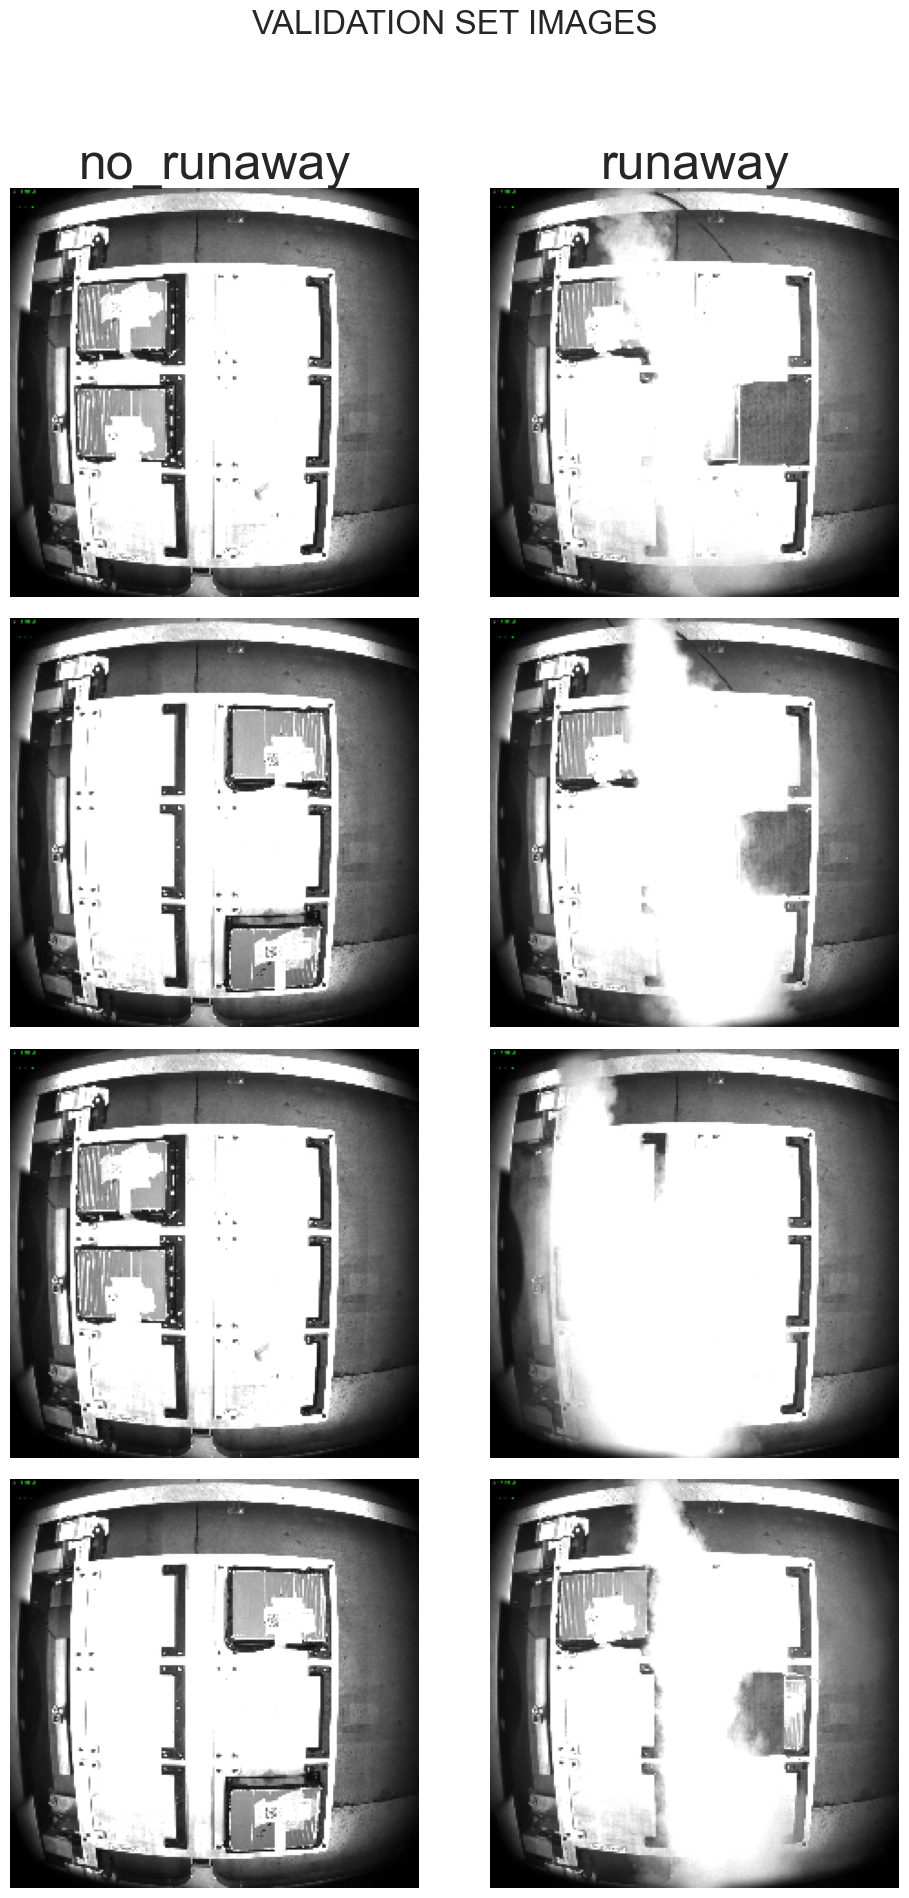

<Figure size 640x480 with 0 Axes>

In [30]:
if hyper_input_channels == 6:    
    plot_label_examples_fused(augmented_val_images, augmented_val_labels, figure_title="VALIDATION SET IMAGES")
    plt.tight_layout()
    plt.show()
else:
    plot_label_examples(augmented_val_images, augmented_val_labels, figure_title="VALIDATION SET IMAGES")
    plt.tight_layout()
    plt.show()    

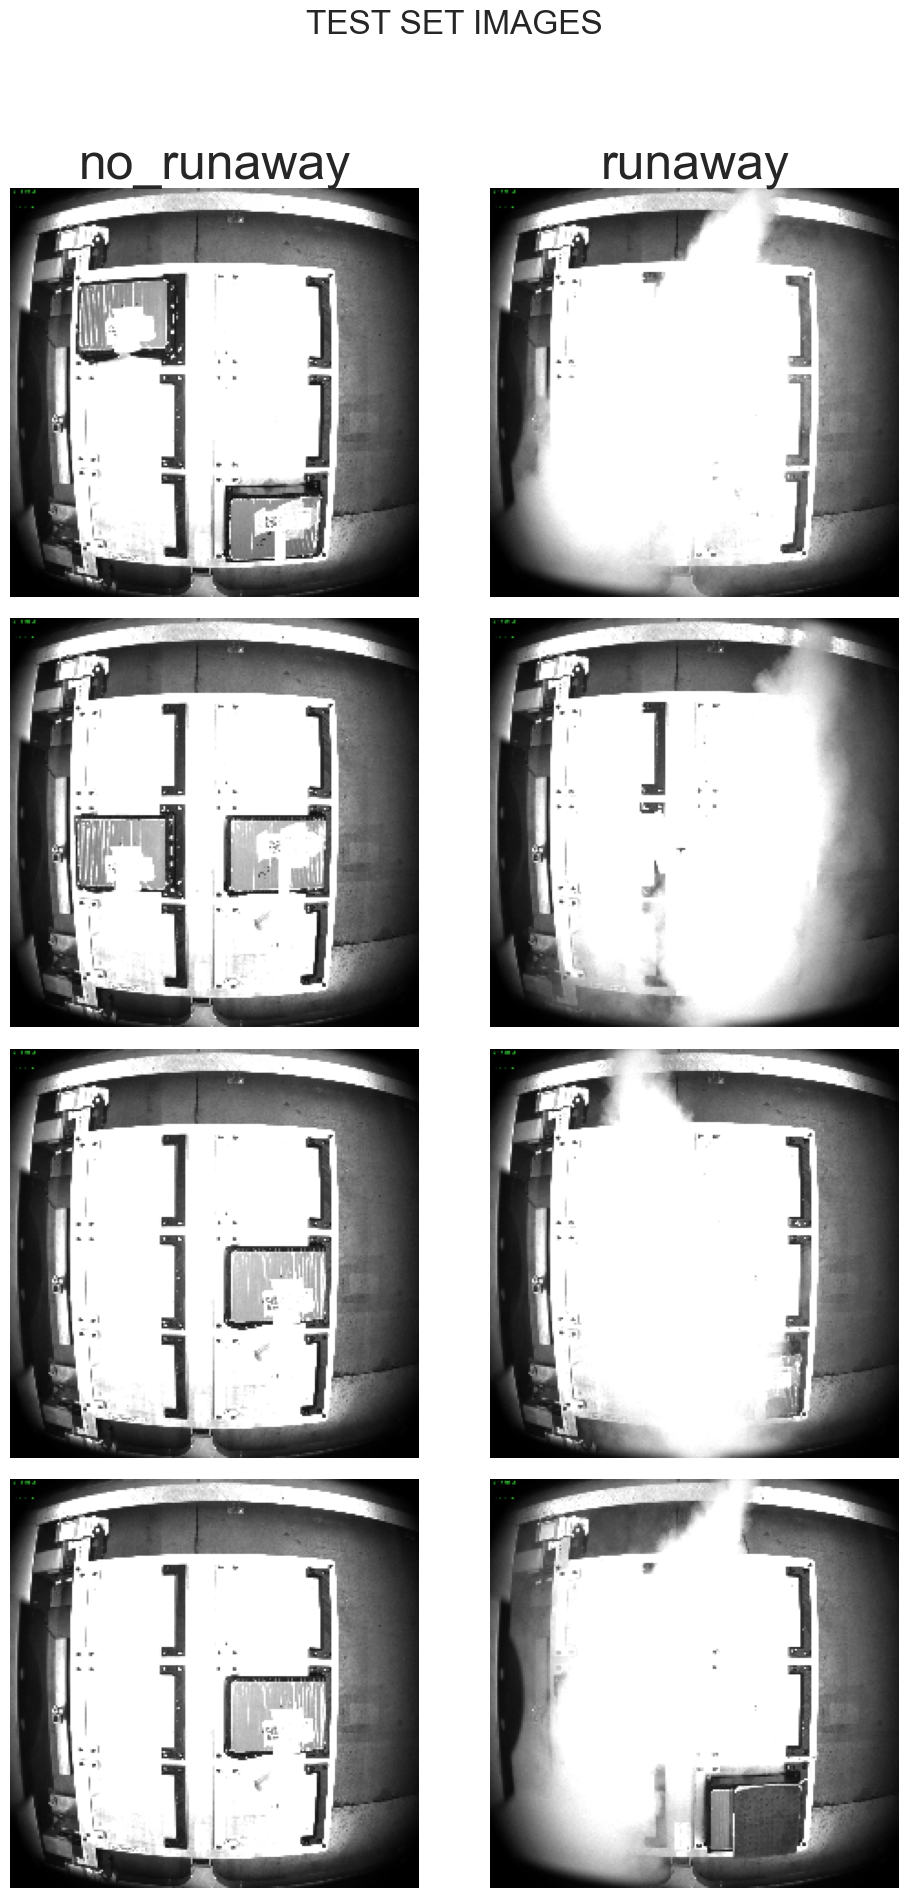

<Figure size 640x480 with 0 Axes>

In [31]:
if hyper_input_channels == 6:  
    plot_label_examples_fused(augmented_test_images, augmented_test_labels, figure_title="TEST SET IMAGES")
    plt.tight_layout()
    plt.show()
else:
    plot_label_examples(augmented_test_images, augmented_test_labels, figure_title="TEST SET IMAGES")
    plt.tight_layout()
    plt.show()    

In [32]:
###  SHUFFLE THE IMAGES AND LABELS FOR MORE UNBIASED TRAINING

augmented_train_images, augmented_train_labels = shuffle(augmented_train_images, augmented_train_labels, random_state=42)
augmented_val_images, augmented_val_labels = shuffle(augmented_val_images, augmented_val_labels, random_state=42)
augmented_test_images, augmented_test_labels = shuffle(augmented_test_images, augmented_test_labels, random_state=42)

In [33]:
print(augmented_train_images.shape, augmented_train_labels.shape)
print('')
print(augmented_val_images.shape, augmented_val_labels.shape)
print('')
print(augmented_test_images.shape, augmented_test_labels.shape)

(562, 3, 224, 224) (562,)

(120, 3, 224, 224) (120,)

(153, 3, 224, 224) (153,)


### Image dataset and Dataloader Classes

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### FOR CNNS WHICH EXPECT GRAYSCALE IMAGE

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Custom dataset to convert images and labels to tensors.

        Parameters:
        - images: Numpy array of images.
        - labels: Numpy array of labels corresponding to each image.
        - transform: Optional transform to be applied on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [35]:
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from transformers import ViTFeatureExtractor

c:\Users\N\Desktop\UM COURSES\Data Mining\Churn_test\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
batch_size = 32 ### ADJUST BASED ON AVAILABLE VRAM

train_dataset = CustomImageDataset(augmented_train_images, augmented_train_labels, transform=None)  ######################################################################################################
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f'LENGTH OF TRAIN DATASET:{len(train_dataset)}')
print(f'LENGTH OF TRAIN DATALOADER:{len(train_dataloader)}')

val_dataset= CustomImageDataset(augmented_val_images, augmented_val_labels, transform=None)         ######################################################################################################
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(f'LENGTH OF VALIDATION DATASET:{len(val_dataset)}')
print(f'LENGTH OF VALIDATION DATALOADER:{len(val_dataloader)}')

test_dataset = CustomImageDataset(augmented_test_images, augmented_test_labels, transform=None)     ######################################################################################################
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
print(f'LENGTH OF TEST DATASET:{len(test_dataset)}')
print(f'LENGTH OF TEST DATALOADER:{len(test_dataloader)}')

LENGTH OF TRAIN DATASET:562
LENGTH OF TRAIN DATALOADER:18
LENGTH OF VALIDATION DATASET:120
LENGTH OF VALIDATION DATALOADER:4
LENGTH OF TEST DATASET:153
LENGTH OF TEST DATALOADER:5


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import random


def plot_label_examples_fused_dataset(dataset_in, random_seed=None, figure_title="Image Samples"):
    """
    Displays 4 random example pairs of images (each split into two 3-channel images) for each label in a subplot,
    with the examples for each label arranged vertically. Each row now contains two images side by side for the same datapoint.
    Allows for setting a random seed for reproducibility.
    
    Parameters:
    - images: A list of images (each one as a numpy array with 6 channels).
    - labels: A list of labels corresponding to each image.
    - random_seed: An optional integer to control randomness for reproducibility.
    """
    
    unique_labels = [0, 1]  ### UNIQUE LABELS
    
    ### CREATE A SUBPLOT WITH 4 ROWS AND 4 COLUMNS
    fig, axs = plt.subplots(4, 2 * len(unique_labels), figsize=(10 * len(unique_labels), 20))
    
    if len(unique_labels) == 1:
        axs = axs.reshape(4, 2)  ### ENSURE THAT AXS IS PROPERLY SHAPED WHEN ONLY 1 LABEL IS DETECTED

    for col, label in enumerate(unique_labels):
        label_indices = [idx for idx, current_label in enumerate(dataset_in[:][1]) if current_label == label]
        random.shuffle(label_indices)  ### RANDOMLY SHUFFLE THE INDICIES OF THE IMAGES
        
        selected_indices = label_indices[:4]
        for row, img_idx in enumerate(selected_indices):
            img = dataset_in[img_idx][0]
            if img.shape[0] == 6:
                img = img.transpose(1,2,0)

            optical_img, ir_img = split_into_ir_optical(img)  ### SPLIT THE 6 CHANNEL IMAGES TO 2 IMAGES OF 3 CHANNELS EACH
            
            ### OPTICAL IMAGE ON THE LEFT
            ax_left = axs[row, 2 * col]
            ax_left.imshow(optical_img)
            ax_left.axis('off')
            
            ### IR IMAGE ON THE RIGHT
            ax_right = axs[row, 2 * col + 1]
            ax_right.imshow(bgr_to_rgb(ir_img))
            ax_right.axis('off')
            
            if row == 0:
                ax_right.set_title(f'Respective {id2label[label]} IR', fontsize=18)  ### TITLE FOR IR
                ax_left.set_title(f'{id2label[label]} Optical', fontsize=18)  ### TITLE FOR OPTICAL

    fig.suptitle(figure_title, fontsize=24, verticalalignment='top')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


#plot_label_examples_fused_dataset(train_dataset, random_seed=42, figure_title = "TRAIN IMAGE EXAMPLES")
#plot_label_examples_fused(val_images, val_labels, random_seed=42, figure_title = "VALIDATION IMAGE EXAMPLES")
#plot_label_examples_fused(test_images, test_labels, random_seed=42, figure_title = "TEST IMAGE EXAMPLES")

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random


def plot_label_examples_dataset(dataset_in, figure_title="Image Samples"):
    """
    Displays 4 random example pairs of images (each split into two 3-channel images) for each label in a subplot,
    with the examples for each label arranged vertically. Each row now contains two images side by side for the same datapoint.
    Allows for setting a random seed for reproducibility.
    
    Parameters:
    - images: A list of images (each one as a numpy array with 6 channels).
    - labels: A list of labels corresponding to each image.
    - random_seed: An optional integer to control randomness for reproducibility.
    """
    
    unique_labels = [0, 1]  ### UNIQUE LABELS
    
    ### CREATE A SUBPLOT WITH 4 ROWS AND 4 COLUMNS
    fig, axs = plt.subplots(4, len(unique_labels), figsize=(10 * len(unique_labels), 20))
    
    if len(unique_labels) == 1:
        axs = axs.reshape(4, 2)  

    for col, label in enumerate(unique_labels):
        label_indices = [idx for idx, current_label in enumerate(dataset_in[:][1]) if current_label == label]
        random.shuffle(label_indices)  
        
        selected_indices = label_indices[:4]
        for row, img_idx in enumerate(selected_indices):
            img = dataset_in[img_idx][0]
            if img.shape[0] == 3:
                img = img.transpose(1,2,0)
            
            axs[row, col].imshow(bgr_to_rgb(img))
            axs[row, col].axis('off')

    fig.suptitle(figure_title, fontsize=24, verticalalignment='top')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


#plot_label_examples_dataset(train_dataset, random_seed=42, figure_title = "TRAIN IMAGE EXAMPLES")
#plot_label_examples_dataset(val_dataset, random_seed=42, figure_title = "VAL IMAGE EXAMPLES")
#plot_label_examples_dataset(test_dataset, random_seed=42, figure_title = "TEST IMAGE EXAMPLES")


### Model Architectures

In [39]:
### PRINTS COUNT OF TRAINABLE PARAMETERS IN MODEL, IN PYTORCH
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) ### TRAINABLE PARAMETER = REQUIRES GRAD

In [40]:
import torch.nn as nn
import torch.nn.functional as F
### SIMPLE CNN ARCHITECTURE = 2 CONVOLUTIONS AND 2 FULLY CONNECTED LAYERS, EXPECTS GRAYSCALE IMAGE INPUT

class CNN_2(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(hyper_input_channels, 32, kernel_size=3, padding=1)  ### CHANGE NUMBER OF INPUT CHANNELS AS NEEDED
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  
        self.fc2 = nn.Linear(128, num_classes) ### 2 CLASSES IN OUR DATA

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### THIS IS THE 5 LAYER CUSTOM CNN THAT WAS USED IN THE EXPERIMENTS 
class CNN_5(nn.Module):
    def __init__(self):
        super(CNN_5, self).__init__()
        
        self.conv1 = nn.Conv2d(hyper_input_channels, 32, kernel_size=3, padding=1) ### EXPECTS GRAYSCALE IMAGES AS INPUT
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)  ### 5 CONVOLUTIONS IN TOTAL
        self.act = nn.ReLU()
        
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512 * 7 * 7, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)  
        
        self.dropout = nn.Dropout(0.5)
        
    def layer4(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = self.pool(self.act(self.conv3(x)))
        x = self.pool(self.act(self.conv4(x)))
        #x = self.pool(self.act(self.conv5(x)))  ### FOR LATER VISUALIZATIONS
        return x
        
    
    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = self.pool(self.act(self.conv3(x)))
        x = self.pool(self.act(self.conv4(x)))
        x = self.pool(self.act(self.conv5(x)))  
        
        
        x = x.view(-1, 512 * 7 * 7)  
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

In [42]:
# from torchvision.models import resnet50
# model = resnet50(pretrained=True)
# model.fc = torch.nn.Linear(model.fc.in_features, 2) ### REPLACE LAST FULLY CONNECTED LAYER TO OUTPUT 2 CLASSES
# model

# ### RESNET FOR FUSED 6 CHANNEL IMAGES
# import torch
# import torch.nn as nn
# import torchvision.models as models

# original_first_layer = model.conv1
# # Create a new layer with 6 input channels
# new_first_layer = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
# # Copy weights from the first 3 channels to the next 3 channels
# with torch.no_grad():
#     new_first_layer.weight[:, :3] = original_first_layer.weight.clone()
#     new_first_layer.weight[:, 3:] = original_first_layer.weight.clone()

# # Replace the first layer
# model.conv1 = new_first_layer

# TRAINING MODELS

In [43]:
### THE BELOW CELLS CONTAIN THE ACTUAL TRAINING OF ALL MODELS
### AFTER EVERY RUN, THE BEST PERFORMING MODEL IS SAVED LOCALLY
### ONLY RUN THE FOLLOWING CELLS IF YOU INTEND TO TRAIN THE MODELS!

### SIMPLE 2 LAYER CNN, NO AUGMENT, NO RESAMPLE

In [70]:
model = CNN_5()
#model = CNN_2()
print(model)
print(f"Number of trainable parameters: {count_parameters(model):,}")

CNN_5(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of trainable parameters: 14,480,066


In [71]:
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split

filename_model = model.__class__.__name__
### filename_params = "" ### ALREADY DEFINED AT THE START OF THE NOTEBOOK

filename = filename_model+"_"+filename_params

filename_optimizer = filename+"OPTIMIZER"

MODEL_PATH = f'RESULTS/{filename}.pth'
OPTIMIZER_PATH = f'RESULTS/{filename_optimizer}.pth'


criterion = nn.CrossEntropyLoss() ### CROSS ENTROPY FOR LOSS FUNCTION
optimizer = optim.AdamW(model.parameters(), lr=hyper_learning_rate) ### LEARNING RATE PICKED AFTER MANY EXPERIMENTS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ### TRAIN ON GPU IF AVAILABLE
print(device)

model.to(device)
train_losses = []
val_losses = []
no_improve_epochs = 0
min_val_loss = float('inf')

num_epochs = 7  ### TOTAL TRAIN EPOCHS 
early_stopping_criteria = 20 ### STOP TRAINING IF VALIDATION LOSS DOES NOT DECREASE AFTER THIS MANY EPOCHS

print(f"BEGINNING TRAINING, SAVING RESULTS AT: {MODEL_PATH}")

### TRAINING LOOP
for epoch in range(num_epochs):
    model.train() ### SET MODEL FOR TRAINING
    running_loss = 0.0 ### ZERO TRAIN LOSS FOR EACH BATCH
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch'):
        images, labels = images.to(device), labels.to(device) ### MOVE TO DEVICE

        optimizer.zero_grad() ### ZERO THE OPTIMIZER GRADS

        outputs = model(images) ### PASS THE BATCH FORWARD THROUGH THE MODEL
        loss = criterion(outputs, labels.long()) ### CALCULATE LOSS FUNCTION
        loss.backward() ### COMPUTE GRAPH
        optimizer.step() ### UPDATE WEIGHTS

        running_loss += loss.item() * images.size(0) ### UPDATE RUNNING LOSS

    epoch_loss = running_loss / len(train_dataloader.dataset) ### AVERAGE TRAIN LOSS
    train_losses.append(epoch_loss) ### KEEP TRACK OF TRIAN LOSSES
    print(f"Training Loss: {epoch_loss:.4f}")

    ### VALIDATION LOOP
    model.eval() ### WE DO NOT NEED GRADIENS IN VALIDATION LOOP
    with torch.no_grad():
        val_running_loss = 0.0
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device) ### MOVE TO DEVICE

            outputs = model(images) ### FORWARD 
            loss = criterion(outputs, labels.long()) ### LOSS CALCULATION

            val_running_loss += loss.item() * images.size(0) ### UPDATE VALIDATION RUNNING LOSS

        val_epoch_loss = val_running_loss / len(val_dataloader.dataset) ### AVERAGE VALIDATION LOSS
        val_losses.append(val_epoch_loss)

        print(f"Validation Loss: {val_epoch_loss:.4f}")
        
        if val_epoch_loss < min_val_loss: ### CURRENT MODEL IS BETTER THAN THE BEST ONE SAVED UNTIL NOW
            min_val_loss = val_epoch_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), MODEL_PATH) ### SAVE MODEL DICT
            #torch.save(optimizer.state_dict(), OPTIMIZER_PATH) ### SAVE OPTIMIZER DICT, IN CASE WE WANT TO CONTINUE TRAINING AFTER 20 EPOCHS
            print('SUCCESSFULLY SAVED BEST MODEL AND OPTIMIZER UNTIL NOW') ### WE SAVE OPTIMIZER DICT TO KEEP THE MOMENTUMS OF EACH WEIGHT
            ### OPTIMIZER SAVING TAKES MORE SPACE THAN MODEL ITSELF, SO IF SPACE IS LIMITED, COMMENT THE LINE ABOVE
            
        else:
            no_improve_epochs += 1 
    
        if no_improve_epochs >= early_stopping_criteria:
            print(f"Stopping early at epoch {epoch+1} due to no improvement in validation loss.")
            break    



cuda
BEGINNING TRAINING, SAVING RESULTS AT: RESULTS/CNN_5_OPTICAL_NO_RESAMPLE_NO_AUG.pth


Epoch 1/7: 100%|██████████| 18/18 [00:01<00:00, 13.42batch/s]


Training Loss: 0.6911


100%|██████████| 4/4 [00:00<00:00, 47.14it/s]


Validation Loss: 0.6890
SUCCESSFULLY SAVED BEST MODEL AND OPTIMIZER UNTIL NOW


Epoch 2/7: 100%|██████████| 18/18 [00:01<00:00, 16.34batch/s]


Training Loss: 0.6860


100%|██████████| 4/4 [00:00<00:00, 51.14it/s]


Validation Loss: 0.6799
SUCCESSFULLY SAVED BEST MODEL AND OPTIMIZER UNTIL NOW


Epoch 3/7: 100%|██████████| 18/18 [00:01<00:00, 16.18batch/s]


Training Loss: 0.6682


100%|██████████| 4/4 [00:00<00:00, 47.62it/s]


Validation Loss: 0.6444
SUCCESSFULLY SAVED BEST MODEL AND OPTIMIZER UNTIL NOW


Epoch 4/7: 100%|██████████| 18/18 [00:01<00:00, 16.26batch/s]


Training Loss: 0.6070


100%|██████████| 4/4 [00:00<00:00, 48.04it/s]


Validation Loss: 0.5352
SUCCESSFULLY SAVED BEST MODEL AND OPTIMIZER UNTIL NOW


Epoch 5/7: 100%|██████████| 18/18 [00:01<00:00, 16.24batch/s]


Training Loss: 0.4225


100%|██████████| 4/4 [00:00<00:00, 47.05it/s]


Validation Loss: 0.2827
SUCCESSFULLY SAVED BEST MODEL AND OPTIMIZER UNTIL NOW


Epoch 6/7: 100%|██████████| 18/18 [00:01<00:00, 16.26batch/s]


Training Loss: 0.1808


100%|██████████| 4/4 [00:00<00:00, 47.03it/s]


Validation Loss: 0.0486
SUCCESSFULLY SAVED BEST MODEL AND OPTIMIZER UNTIL NOW


Epoch 7/7: 100%|██████████| 18/18 [00:01<00:00, 16.31batch/s]


Training Loss: 0.0615


100%|██████████| 4/4 [00:00<00:00, 47.04it/s]

Validation Loss: 0.0094
SUCCESSFULLY SAVED BEST MODEL AND OPTIMIZER UNTIL NOW


In [72]:
model.load_state_dict(torch.load(MODEL_PATH)) ### LOAD BEST MODEL, BECAUSE LAST EPOCH MAY NOT BE THE BEST

<All keys matched successfully>

In [73]:
from sklearn.metrics import classification_report, confusion_matrix

true_labels = []
pred_labels = []
logits = []  
labels_list = ['no_runaway', 'runaway'] ### ORIGINAL LABELS FROM DATASET

model.eval()
### TESTING LOOP
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device) ### MOVE TO DEVICE

        outputs = model(images) ### FORWARD 
        logits.extend(outputs.cpu().numpy()) 
            
        
        _, predicted = torch.max(outputs.data, 1) ### GET THE ACTUAL PREDICTIONS

        ### KEEP TRACK OF PREDICTIONS AND ACTUAL LABELS FOR FURTHER METRIC COMPUTATION
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())


report = classification_report(true_labels, pred_labels, target_names=labels_list)

print(report)

100%|██████████| 5/5 [00:00<00:00, 10.42it/s]

              precision    recall  f1-score   support

  no_runaway       1.00      1.00      1.00        73
     runaway       1.00      1.00      1.00        80

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



[[73  0]
 [ 0 80]]
File Images/CNN_5_OPTICAL_NO_RESAMPLE_NO_AUG_Confusion_matrix.png already exists, OVERWRITTING !!!!!!!.


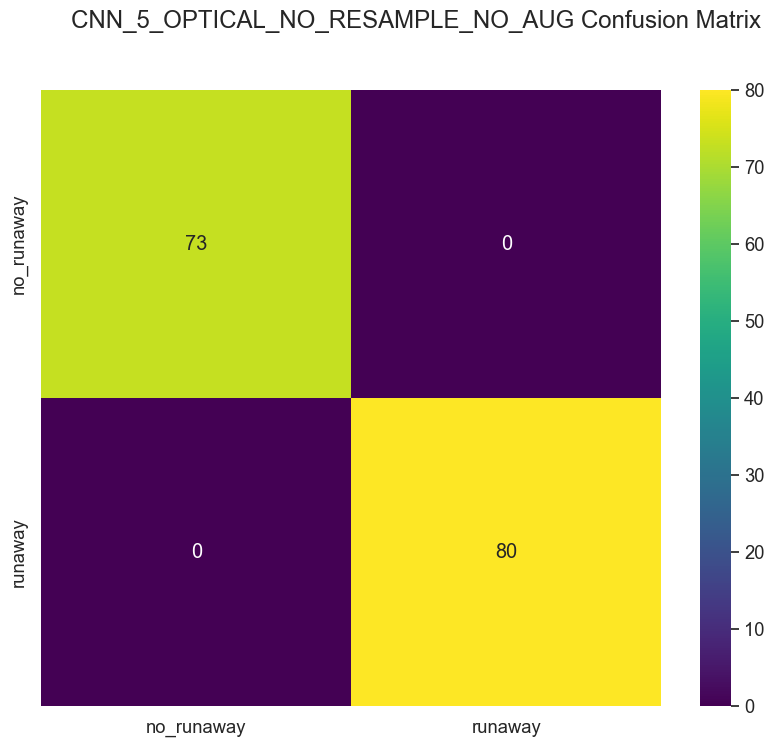

In [74]:
from sklearn.metrics import confusion_matrix

conf = confusion_matrix(true_labels, pred_labels)

print(conf)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(conf, annot=True, cmap='viridis', fmt='g', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
filename = filename_model+"_"+filename_params
fig.suptitle(f"{filename} Confusion Matrix")

save_filename = f"Images/{filename}_Confusion_matrix.png"
if not os.path.exists(save_filename):
    plt.savefig(save_filename, bbox_inches='tight')
    print(f"Image Successfully Saved at {save_filename}")
else:
    print(f"File {save_filename} already exists, OVERWRITTING !!!!!!!.")
    plt.savefig(save_filename, bbox_inches='tight')

plt.show()

File Images/CNN_5_OPTICAL_NO_RESAMPLE_NO_AUG_Training_Validation_Losses.png already exists, OVERWRITTING !!!!!!!.


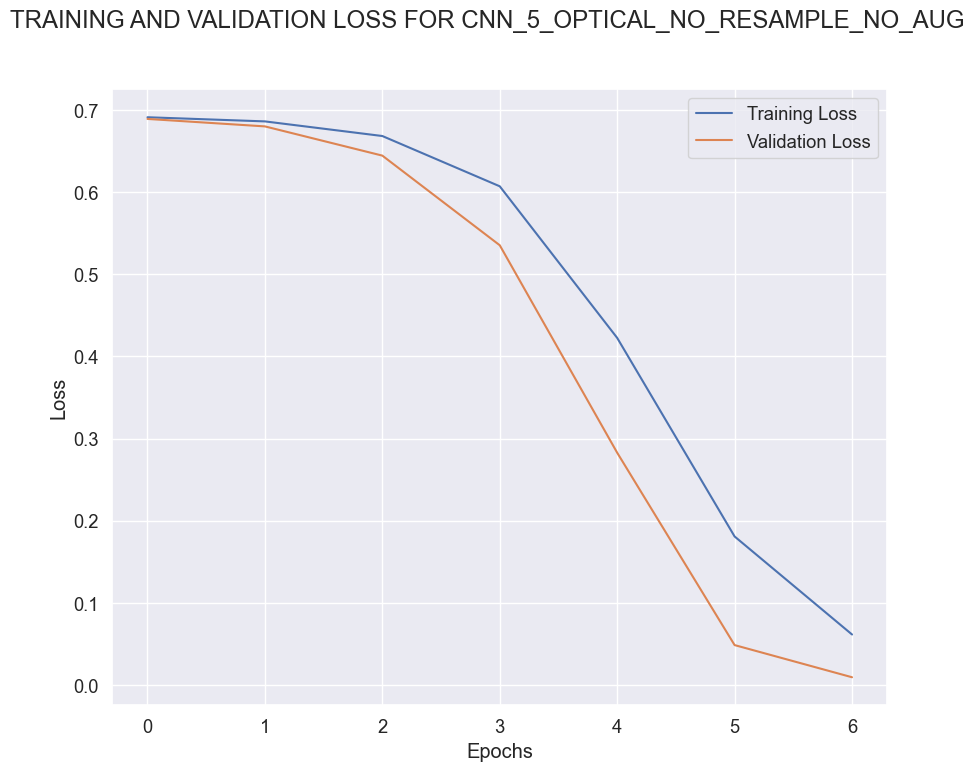

In [75]:
### PLOTTING THE TRAINING AND VALIDATION LOSSES

fig, ax = plt.subplots(figsize=(10,8))

filename = filename_model+"_"+filename_params
fig.suptitle(f'TRAINING AND VALIDATION LOSS FOR {filename}')

if train_losses[0] > 1:
    ax.plot(train_losses[1:], label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    filename = filename_model+"_"+filename_params
    save_filename = f"Images/{filename}_Training_Validation_Losses.png"
    if not os.path.exists(save_filename):
        plt.savefig(save_filename, bbox_inches='tight')
        print(f"Image Successfully Saved at {save_filename}")
    else:
        print(f"File {save_filename} already exists, OVERWRITTING !!!!!!!.")
        plt.savefig(save_filename, bbox_inches='tight')
else:
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    filename = filename_model+"_"+filename_params
    save_filename = f"Images/{filename}_Training_Validation_Losses.png"
    if not os.path.exists(save_filename):
        plt.savefig(save_filename, bbox_inches='tight')
        print(f"Image Successfully Saved at {save_filename}")
    else:
        print(f"File {save_filename} already exists, OVERWRITTING !!!!!!!.")
        plt.savefig(save_filename, bbox_inches='tight')

    plt.show()

File Images/CNN_5_OPTICAL_NO_RESAMPLE_NO_AUG_ROC_Curves.png already exists, OVERWRITTING !!!!!!!.


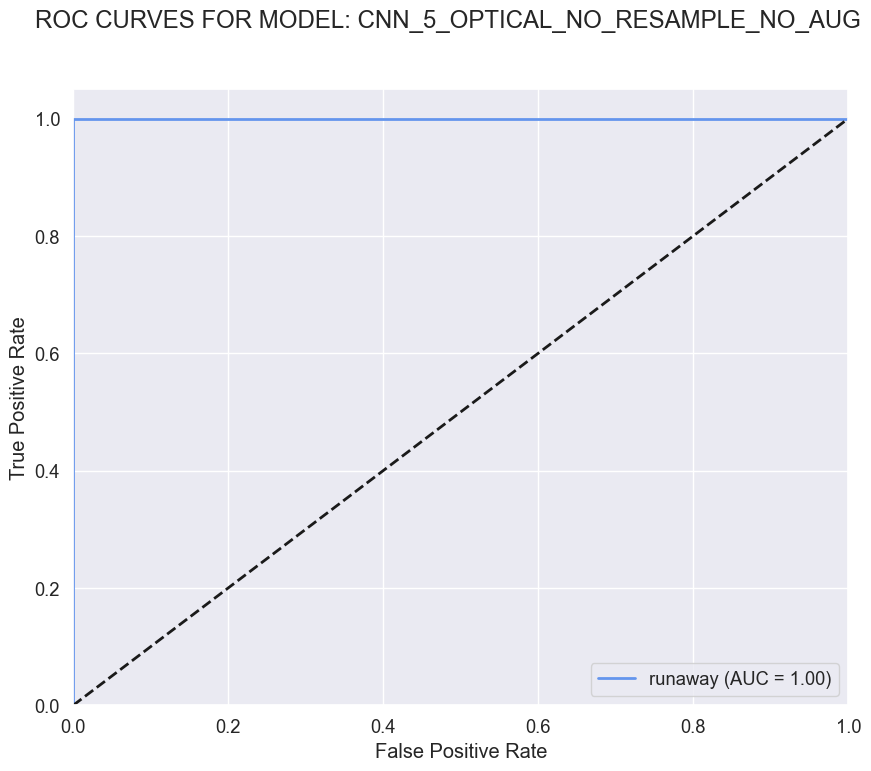

In [76]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

labels_list = class_labels  # ORIGINAL LABELS FROM DATASET

n_classes = len(class_labels)

logits = np.array(logits)

y_score = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
#y_score = y_score[:, 1]  # Use the scores for the positive class

fpr, tpr, _ = roc_curve(true_labels, y_score[:, 1])
#fpr, tpr, _ = roc_curve(y_bin[:, 0], y_score)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(fpr, tpr, color="cornflowerblue", lw=2, label=f'{labels_list[1]} (AUC = {roc_auc:0.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
fig.suptitle(f'ROC CURVES FOR MODEL: {filename}')
ax.legend(loc="best")
filename = filename_model+"_"+filename_params
save_filename = f"Images/{filename}_ROC_Curves.png"
if not os.path.exists(save_filename):
    plt.savefig(save_filename, bbox_inches='tight')
    print(f"Image Successfully Saved at {save_filename}")
else:
    print(f"File {save_filename} already exists, OVERWRITTING !!!!!!!.")
    plt.savefig(save_filename, bbox_inches='tight')
plt.show()


In [77]:
type(true_labels)

list

In [78]:
logits.shape

(153, 2)

File Images/CNN_5_OPTICAL_NO_RESAMPLE_NO_AUG_Precision_Recall.png already exists, OVERWRITTING !!!!!!!.


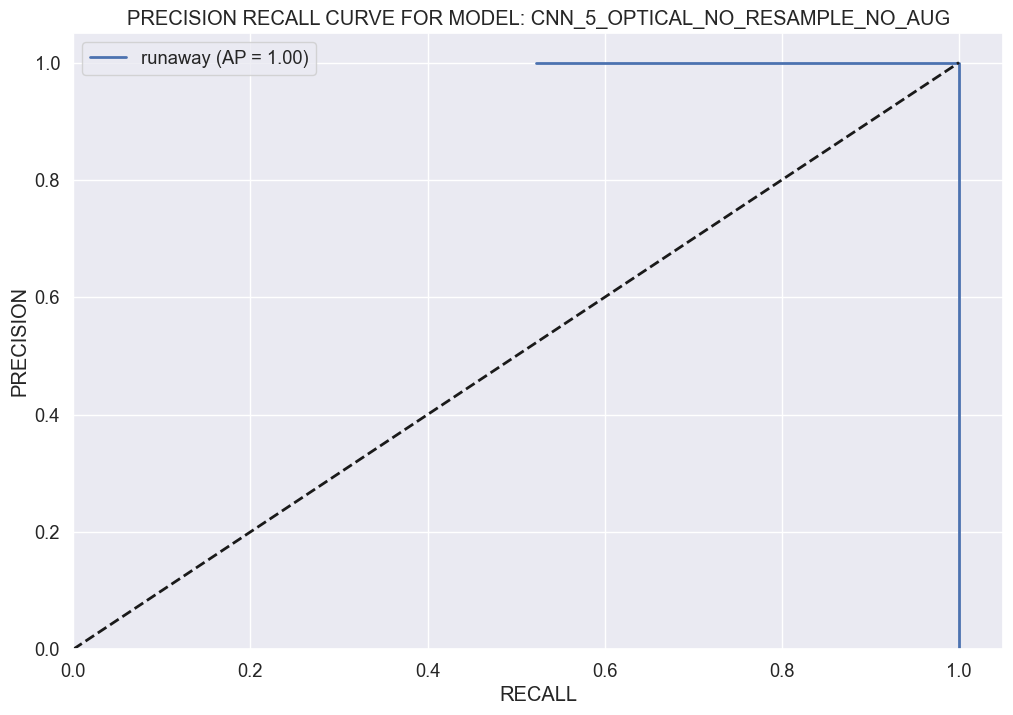

In [79]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

y_score = np.exp(np.array(logits)) / np.exp(np.array(logits)).sum(axis=1, keepdims=True)


precision, recall, thresholds = precision_recall_curve(true_labels, logits[:, 1]) ### PRECISION RECALL FUNCTION FROM SKLEARN
average_precision = average_precision_score(true_labels, logits[:, 1])

plt.figure(figsize=(12,8))

plt.plot(precision, recall, lw=2, label=f'{labels_list[1]} (AP = {average_precision:0.2f})')  

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('RECALL')
plt.ylabel('PRECISION')
plt.title(f'PRECISION RECALL CURVE FOR MODEL: {filename_model+"_"+filename_params}')  
plt.legend(loc="best")
filename = filename_model+"_"+filename_params
save_filename = f"Images/{filename}_Precision_Recall.png"
if not os.path.exists(save_filename):
    plt.savefig(save_filename, bbox_inches='tight')
    print(f"Image Successfully Saved at {save_filename}")
else:
    print(f"File {save_filename} already exists, OVERWRITTING !!!!!!!.")
    plt.savefig(save_filename, bbox_inches='tight')

plt.show()

# Grad-CAM

### Functions for Resnet Gradcam

In [80]:
### CUSTOM GRAD-CAM MODULE FOR RESNET
### USED TO SEE IF THERE ARE DIFFERENCES BETWEEN GARD-CAM MODULE AND MY CUSTOM GRAD-CAM FUNCTIONS
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

### Grad-CAM

In [82]:
### CUSTOM GRAD-CAM MODULE FOR RESNET
### USED TO SEE IF THERE ARE DIFFERENCES BETWEEN GARD-CAM MODULE AND MY CUSTOM GRAD-CAM FUNCTIONS
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import time

In [83]:
def get_resnet_gradcam_fusion(model, dataset, test_index):

    if "2" in filename_model:
        target_layers = [model.conv2]
    elif "5" in filename_model:
        target_layers = [model.conv5]
    elif "ResNet" in filename_model:
        target_layers = [model.layer4[-1]]
    else:
        print("ERROR, PLEASE SELECT THE CORRECT TARGET LAYER")    

    input_tensor = torch.tensor(dataset[test_index][0]) 
    input_tensor = torch.clamp(input_tensor, 0, 255) ###################################################################
    input_tensor = input_tensor.unsqueeze(0).to(device)

    true_label = dataset[test_index][1]

    #input_tensor = dataset[test_index][0].unsqueeze(0).to(device) ####### to palio


    cam = GradCAM(model=model, target_layers=target_layers) ### GRAD-CAM MODULE
    logs = model(input_tensor)
    pred_label = id2label[logs.argmax(dim=1).cpu().detach().numpy().tolist()[0]]

    grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=False, eigen_smooth=False) #########################################
    grayscale_cam = grayscale_cam[0, :]

    # test_img_test = augmented_test_images[test_index]/255
    # test_img_test = test_img_test.transpose(1,2,0)

    test_image_optical = split_into_ir_optical(input_tensor.squeeze(0).permute(1,2,0).cpu().numpy())[0]
    test_image_ir = split_into_ir_optical(input_tensor.squeeze(0).permute(1,2,0).cpu().numpy())[1]


    visualization1 = show_cam_on_image(test_image_optical, grayscale_cam, use_rgb=True)
    visualization2 = show_cam_on_image(test_image_ir, grayscale_cam, use_rgb=True)


    #visualization = show_cam_on_image(X_test_rgb[test_index]/255, grayscale_cam, use_rgb=True) ### to palio

       
    #return grayscale_cam, pred_label
    return visualization1, visualization2, pred_label, test_image_optical, test_image_ir, true_label

##########################################################################################################################################################################
##########################################################################################################################################################################
##########################################################################################################################################################################
def get_resnet_gradcam_non_fusion(model, dataset, test_index):

    if "2" in filename_model:
        target_layers = [model.conv2]
    elif "5" in filename_model:
        target_layers = [model.conv5]
    elif "ResNet" in filename_model:
        target_layers = [model.layer4[-1]]
    else:
        print("ERROR, PLEASE SELECT THE CORRECT TARGET LAYER")  

    input_tensor = torch.tensor(dataset[test_index][0]) 
    input_tensor = torch.clamp(input_tensor, 0, 255) ###################################################################
    input_tensor = input_tensor.unsqueeze(0).to(device)
    true_label = dataset[test_index][1]



    cam = GradCAM(model=model, target_layers=target_layers) ### GRAD-CAM MODULE
    logs = model(input_tensor)
    pred_label = id2label[logs.argmax(dim=1).cpu().detach().numpy().tolist()[0]]

    grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=False, eigen_smooth=False) #########################################
    grayscale_cam = grayscale_cam[0, :]


    test_image = input_tensor.squeeze(0).permute(1,2,0).cpu().numpy()


    visualization1 = show_cam_on_image(test_image, grayscale_cam, use_rgb=True)

    return visualization1, pred_label, test_image, true_label

def get_simple_gradcam(model, dataset, test_index):

    model.eval()

    target_layers = [model.layer4[-1]] #########
    #target_layers = [model.conv2]
    #target_layers = [model.conv5] ###########
    #input_tensor = dataset[test_index][0].unsqueeze(0).to(device) #########################

    input_tensor = torch.tensor(dataset[test_index][0]).unsqueeze(0).to(device) #########################
    true_label = dataset[test_index][1]

    print(input_tensor.get_device())
    cam = GradCAM(model=model, target_layers=target_layers) ### GRAD-CAM MODULE
    logs = model(input_tensor)

    print('finished forward pass')
    pred_label = id2label[logs.argmax(dim=1).cpu().detach().numpy().tolist()[0]]

    start = time.time()
    grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=True, eigen_smooth=False)
    end = time.time()

    print(end-start)
    print('finished gradcam computation')

    print('starting cam visualization')
    grayscale_cam = grayscale_cam[0, :]
    #visualization = show_cam_on_image(X_test_rgb[test_index]/255, grayscale_cam, use_rgb=True) ###########################

    test_img_test = augmented_test_images[test_index]/255
    test_img_test = test_img_test.transpose(1,2,0)

    test_image_ir = split_into_ir_optical(test_img_test)
    
    visualization1 = show_cam_on_image(test_image_ir[0], grayscale_cam, use_rgb=True) ###########################
    visualization2 = show_cam_on_image(test_image_ir[1], grayscale_cam, use_rgb=True) ###########################


    print('finished visualization')

    #return grayscale_cam, pred_label   
    return visualization1, visualization2, pred_label, true_label

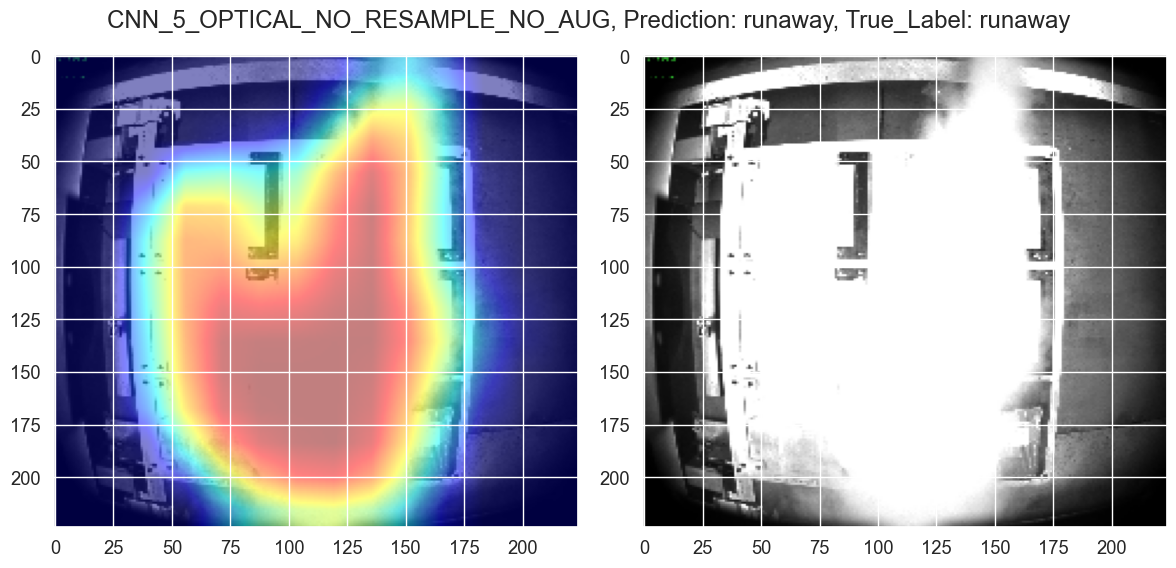

In [84]:
testme = 0
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    

#########################

#kala indices gia resnet50

#14

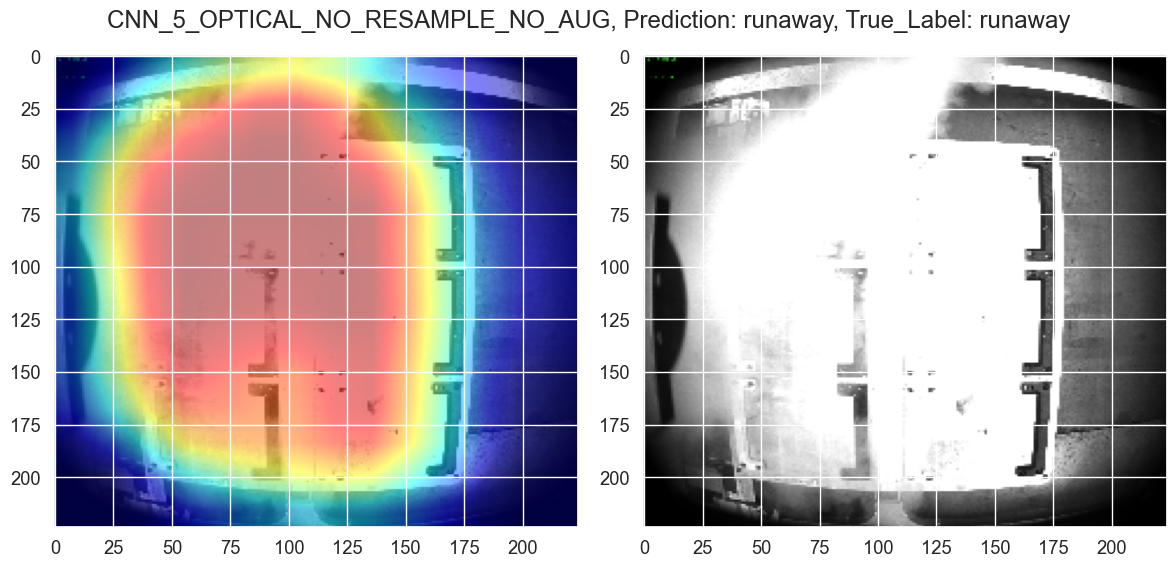

In [85]:
testme = 3
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    

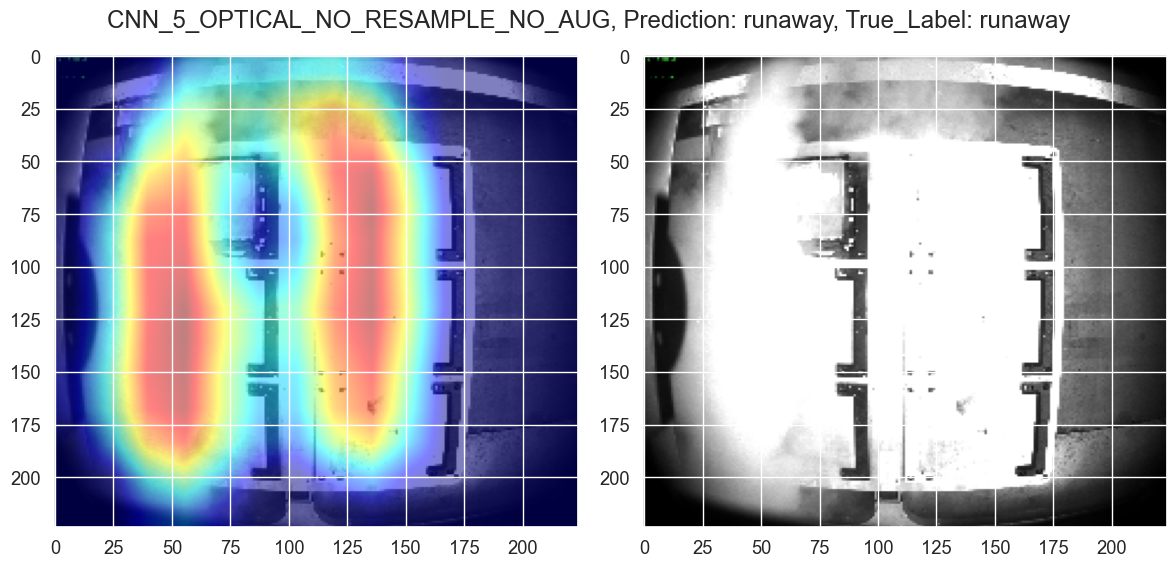

In [86]:
testme = 21
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    

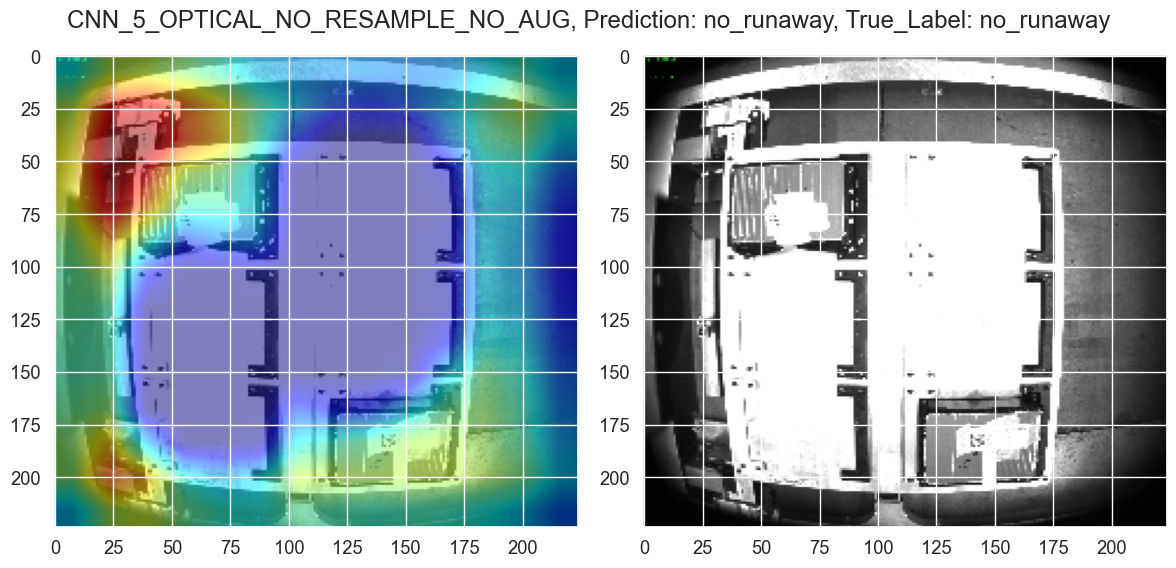

In [87]:
testme = 22
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    

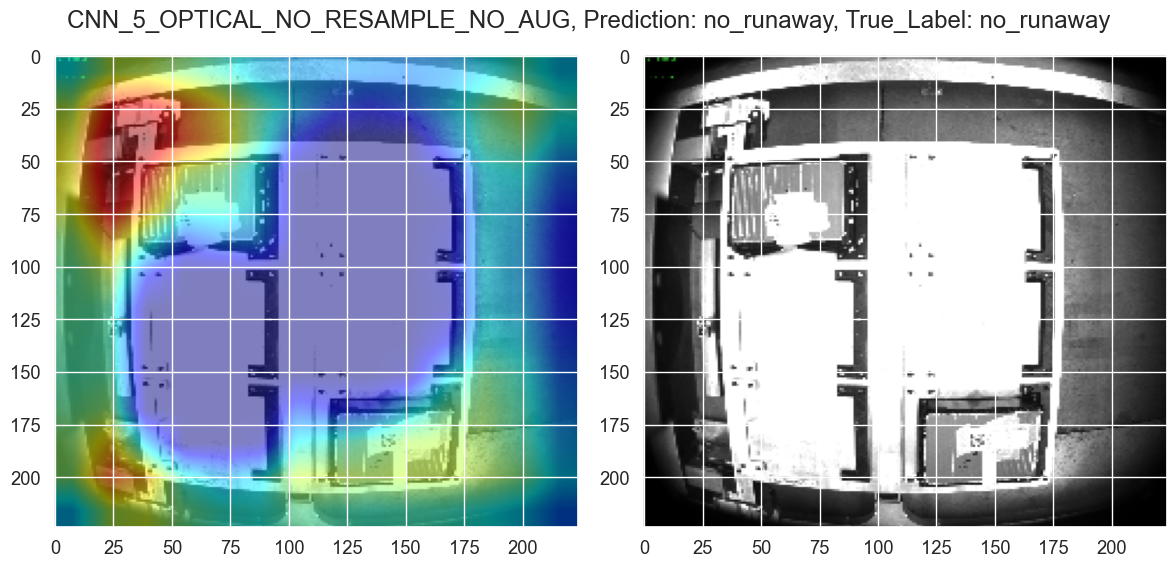

In [88]:
testme = 4
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    

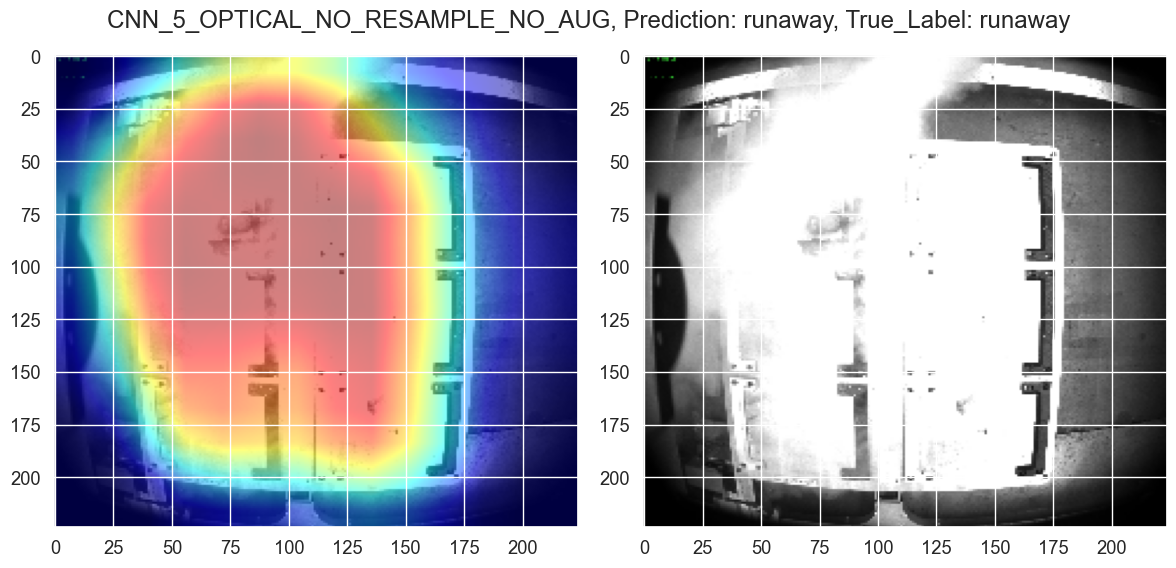

In [89]:
testme = 5
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    

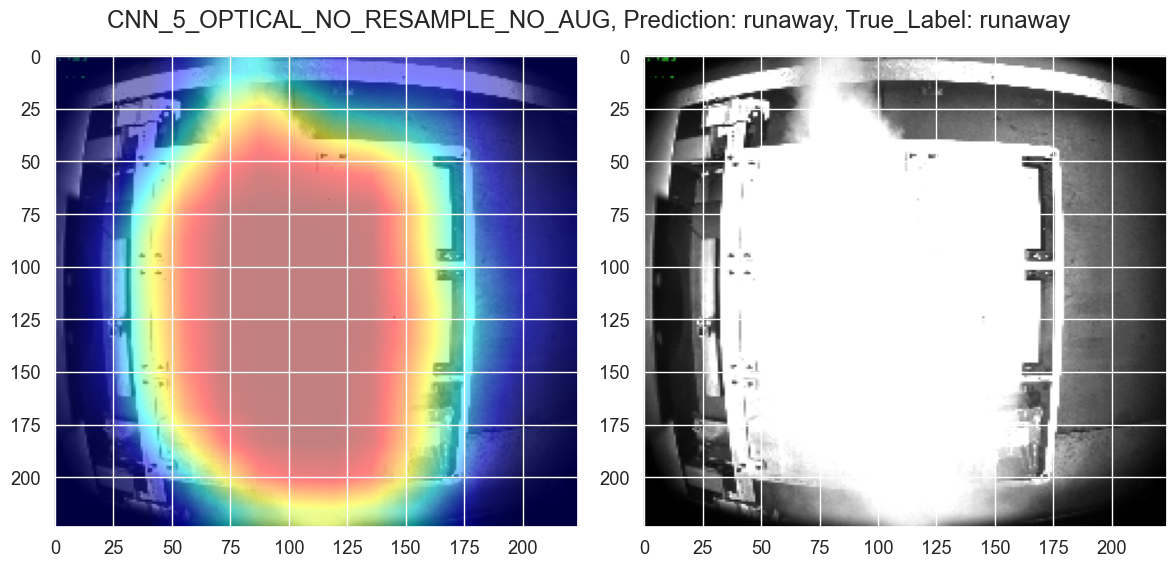

In [90]:
testme = 6
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    

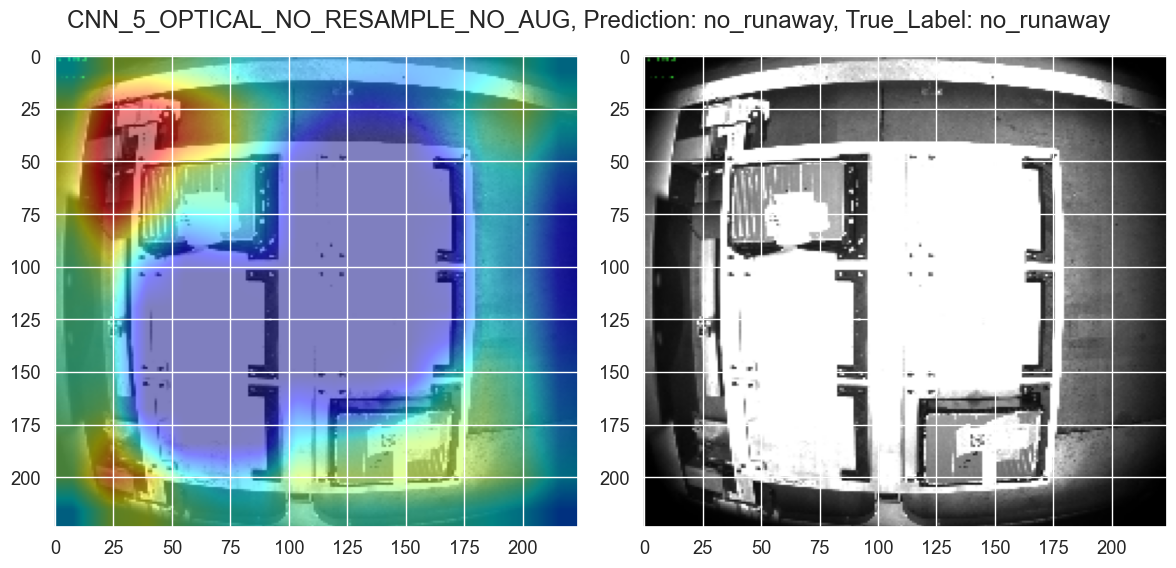

In [91]:
testme = 33
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    

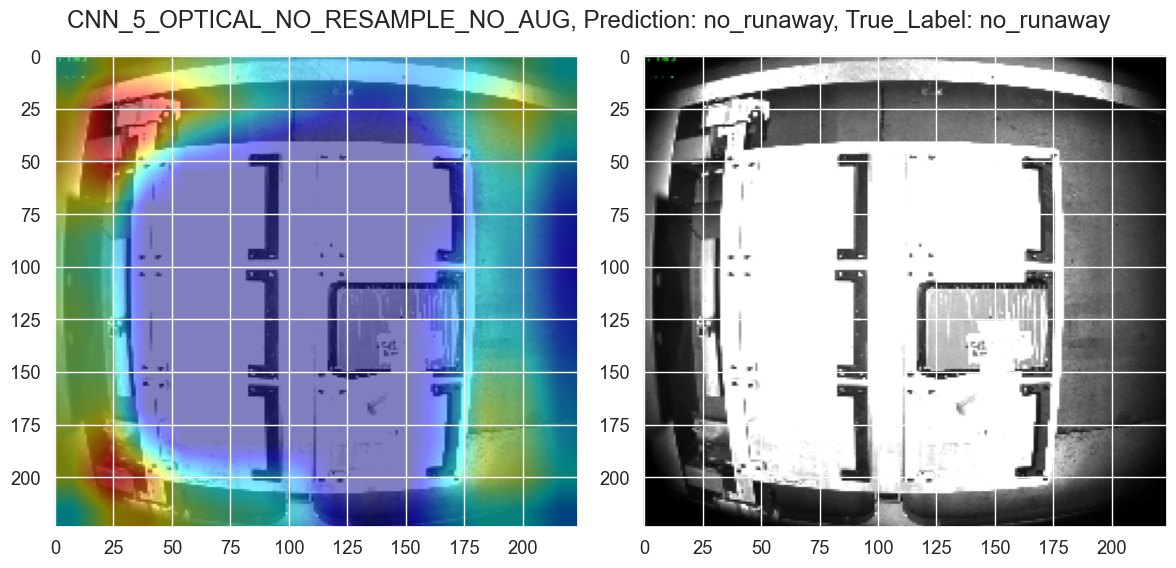

In [92]:
testme = 34
if "FUSION" in filename_params:
    vis1, vis2, prr, opt, ir, true_lab = get_resnet_gradcam_fusion(model, test_dataset, testme)
    fig, axs = plt.subplots(2,2, figsize=(12,12))
    axs[0,0].imshow(vis1, aspect='auto')
    axs[0,1].imshow(opt, aspect='auto')
    axs[1,0].imshow(vis2, aspect='auto')
    axs[1,1].imshow(bgr_to_rgb(ir), aspect='auto')

    # plt.tight_layout()
    # plt.show()
else:         
    vis1, prr, test_image_test, true_lab = get_resnet_gradcam_non_fusion(model, test_dataset, testme)

    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    axs[0].imshow(vis1, aspect='auto')
    axs[1].imshow(test_image_test, aspect='auto')
    # plt.tight_layout()
    # plt.show()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f"{filename_model}_{filename_params}, Prediction: {prr}, True_Label: {id2label[true_lab]}")
plt.show()    